In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})
from dask.distributed import Client
#client = Client(n_workers=5, threads_per_worker=1,
#                memory_limit="24G",
#                dashboard_address="localhost:8787")

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


In [2]:
 # magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

# Custom functions and tools 
import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from gpmcmc import model_gp

In [3]:
%%time

#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", 
                        columns=['ra', 'dec', 'parallax', 'parallax_over_error', 
                                'bp_rp', 'solution_id', 
                                'source_id', 
                                'pmra', 'pmra_error', 
                                'pmdec', 'pmdec_error', 
                                'parallax_error', 
                                'phot_g_mean_mag', 
                                'l', 'b', 'non_single_star', 
                                'classprob_dsc_combmod_galaxy', 
                                'classprob_dsc_combmod_star', 
                                 'in_qso_candidates',
                                'teff_gspphot', 'teff_gspphot_upper', 'teff_gspphot_lower',
                                'logg_gspphot', 'logg_gspphot_lower', 'logg_gspphot_upper',
                                'mh_gspphot','mh_gspphot_lower', 'mh_gspphot_upper',
                                'distance_gspphot', 'distance_gspphot_lower','distance_gspphot_upper',
                                'azero_gspphot', 'azero_gspphot_lower', 'azero_gspphot_upper', 'ag_gspphot', 
                                 'ebpminrp_gspphot', 'ebpminrp_gspphot_lower', 'ebpminrp_gspphot_upper',
                                'Norder', 'Npix', 'Dir'])

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 1min 11s, sys: 13.8 s, total: 1min 24s
Wall time: 1min 26s


In [4]:
%%time
# load pre-saved FG sample
_sample_hips = lsdb.read_hipscat("/astro/users/atzanida/epyc/ssd/users/atzanida/tmp/data_files/fg_sample")

CPU times: user 2.59 s, sys: 184 ms, total: 2.77 s
Wall time: 2.76 s


In [5]:
%%time
_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 1min 48s, sys: 6.67 s, total: 1min 55s
Wall time: 1min 55s


In [22]:
_sources

,ra_gaia_andy_fg_dwarfs,dec_gaia_andy_fg_dwarfs,parallax_gaia_andy_fg_dwarfs,parallax_over_error_gaia_andy_fg_dwarfs,bp_rp_gaia_andy_fg_dwarfs,solution_id_gaia_andy_fg_dwarfs,source_id_gaia_andy_fg_dwarfs,pmra_gaia_andy_fg_dwarfs,pmra_error_gaia_andy_fg_dwarfs,pmdec_gaia_andy_fg_dwarfs,pmdec_error_gaia_andy_fg_dwarfs,parallax_error_gaia_andy_fg_dwarfs,phot_g_mean_mag_gaia_andy_fg_dwarfs,l_gaia_andy_fg_dwarfs,b_gaia_andy_fg_dwarfs,non_single_star_gaia_andy_fg_dwarfs,classprob_dsc_combmod_galaxy_gaia_andy_fg_dwarfs,classprob_dsc_combmod_star_gaia_andy_fg_dwarfs,in_qso_candidates_gaia_andy_fg_dwarfs,teff_gspphot_gaia_andy_fg_dwarfs,teff_gspphot_upper_gaia_andy_fg_dwarfs,teff_gspphot_lower_gaia_andy_fg_dwarfs,logg_gspphot_gaia_andy_fg_dwarfs,logg_gspphot_lower_gaia_andy_fg_dwarfs,logg_gspphot_upper_gaia_andy_fg_dwarfs,mh_gspphot_gaia_andy_fg_dwarfs,mh_gspphot_lower_gaia_andy_fg_dwarfs,mh_gspphot_upper_gaia_andy_fg_dwarfs,distance_gspphot_gaia_andy_fg_dwarfs,distance_gspphot_lower_gaia_andy_fg_dwarfs,distance_gspphot_upper_gaia_andy_fg_dwarfs,azero_gspphot_gaia_andy_fg_dwarfs,azero_gspphot_lower_gaia_andy_fg_dwarfs,azero_gspphot_upper_gaia_andy_fg_dwarfs,ag_gspphot_gaia_andy_fg_dwarfs,ebpminrp_gspphot_gaia_andy_fg_dwarfs,ebpminrp_gspphot_lower_gaia_andy_fg_dwarfs,ebpminrp_gspphot_upper_gaia_andy_fg_dwarfs,Norder_gaia_andy_fg_dwarfs,Npix_gaia_andy_fg_dwarfs,Dir_gaia_andy_fg_dwarfs,ps1_objid_ztf_dr14_andy_fg_dwarfs,ra_ztf_dr14_andy_fg_dwarfs,dec_ztf_dr14_andy_fg_dwarfs,ps1_gMeanPSFMag_ztf_dr14_andy_fg_dwarfs,ps1_rMeanPSFMag_ztf_dr14_andy_fg_dwarfs,ps1_iMeanPSFMag_ztf_dr14_andy_fg_dwarfs,nobs_g_ztf_dr14_andy_fg_dwarfs,nobs_r_ztf_dr14_andy_fg_dwarfs,nobs_i_ztf_dr14_andy_fg_dwarfs,mean_mag_g_ztf_dr14_andy_fg_dwarfs,mean_mag_r_ztf_dr14_andy_fg_dwarfs,mean_mag_i_ztf_dr14_andy_fg_dwarfs,Norder_ztf_dr14_andy_fg_dwarfs,Dir_ztf_dr14_andy_fg_dwarfs,Npix_ztf_dr14_andy_fg_dwarfs,_DIST_andy_fg_dwarfs,Norder_andy_fg_dwarfs,Dir_andy_fg_dwarfs,Npix_andy_fg_dwarfs,index_ztf_source,ps1_objid_ztf_source,ra_ztf_source,dec_ztf_source,ps1_gMeanPSFMag_ztf_source,ps1_rMeanPSFMag_ztf_source,ps1_iMeanPSFMag_ztf_source,nobs_g_ztf_source,nobs_r_ztf_source,nobs_i_ztf_source,mean_mag_g_ztf_source,mean_mag_r_ztf_source,mean_mag_i_ztf_source,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
npartitions=287241,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int16,int16,float32,float32,float64,int16,string,int32,int32,int32
281474976710656,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13833861786631143424,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

## TAPE

In [6]:
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

# Initialize an Ensemble
ens = Ensemble(n_workers=5, threads_per_worker=1, memory_limit="24G")
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32852 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:32852/status,
Dashboard: http://127.0.0.1:32852/status,Workers: 5
Total threads: 5,Total memory: 111.76 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34285,Workers: 5
Dashboard: http://127.0.0.1:32852/status,Total threads: 5
Started: Just now,Total memory: 111.76 GiB
Comm: tcp://127.0.0.1:40923,Total threads: 1
Dashboard: http://127.0.0.1:36646/status,Memory: 22.35 GiB
Nanny: tcp://127.0.0.1:43039,


In [7]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


## Test Case gr combined

In [128]:
%%time
# know dipper
# working example 4078931319013244928
# good example: 16721355873452032

lc = ens.source.loc[391062914590572544]
lc = lc.compute()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 15.9 s, sys: 1.65 s, total: 17.6 s
Wall time: 18 s


In [135]:
lc.head(1)

,ra_gaia_andy_fg_dwarfs,dec_gaia_andy_fg_dwarfs,parallax_gaia_andy_fg_dwarfs,parallax_over_error_gaia_andy_fg_dwarfs,bp_rp_gaia_andy_fg_dwarfs,solution_id_gaia_andy_fg_dwarfs,source_id_gaia_andy_fg_dwarfs,pmra_gaia_andy_fg_dwarfs,pmra_error_gaia_andy_fg_dwarfs,pmdec_gaia_andy_fg_dwarfs,...,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
391062914590572544,84.116859,43.405593,0.439898,10.388184,0.846287,1636148068921376768,195531448466897408,-0.046876,0.055548,-3.884604,...,-32768,704,18.87701,0.050354,58440.42119,61,g,8,20000,22229


In [129]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

timeg, magg, magerrg = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'].values, band_of_study='g', flag_good=0)

(19.145585345849394, 15.457600017264486)

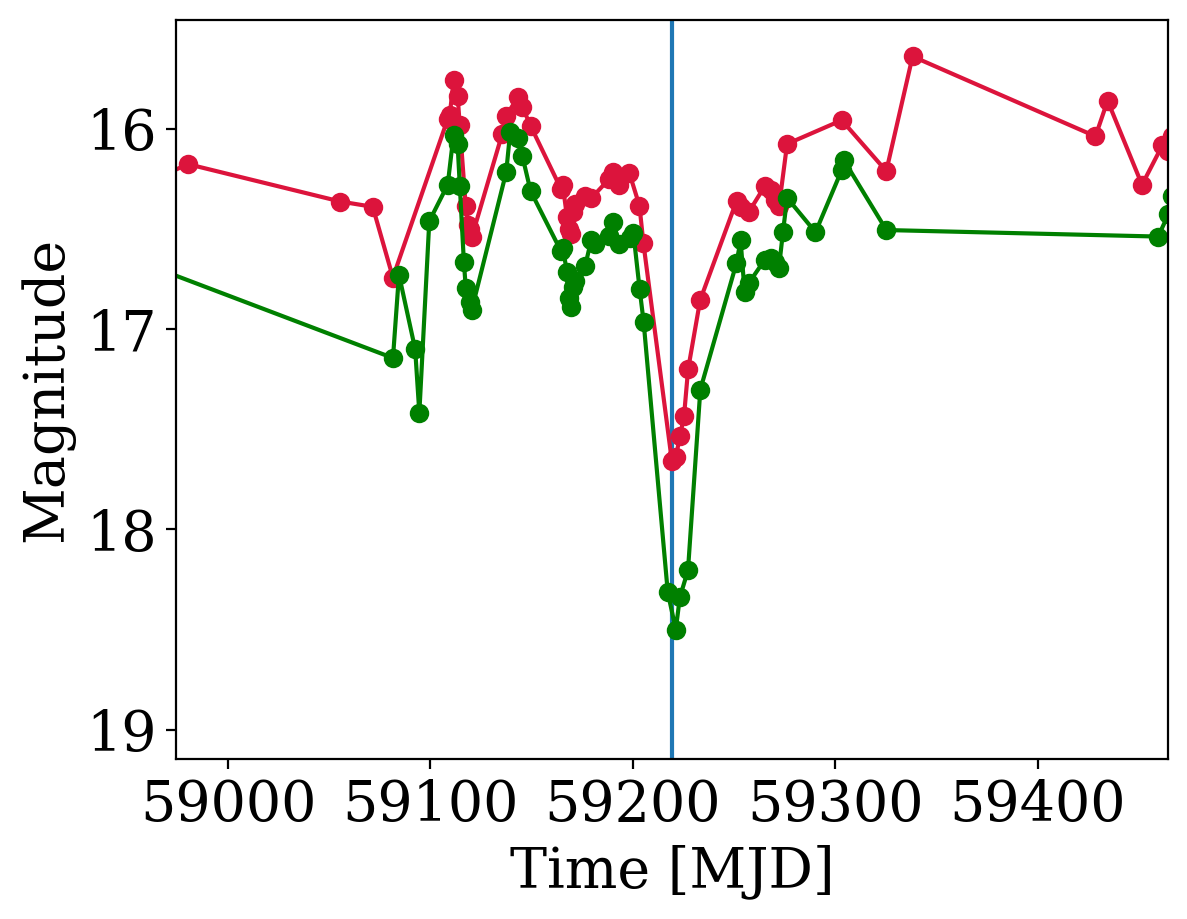

In [133]:
plt.errorbar(time, mag, magerr, fmt='-o', color='Crimson')
plt.errorbar(timeg, magg, magerrg, fmt='-o', color='green')

loc = 59219.26408

plt.xlabel("Time [MJD]")
plt.ylabel("Magnitude")

plt.axvline(loc)
plt.xlim(loc-245, loc+245)

plt.ylim(plt.ylim()[::-1])

Text(0, 0.5, 'Normalized Mag')

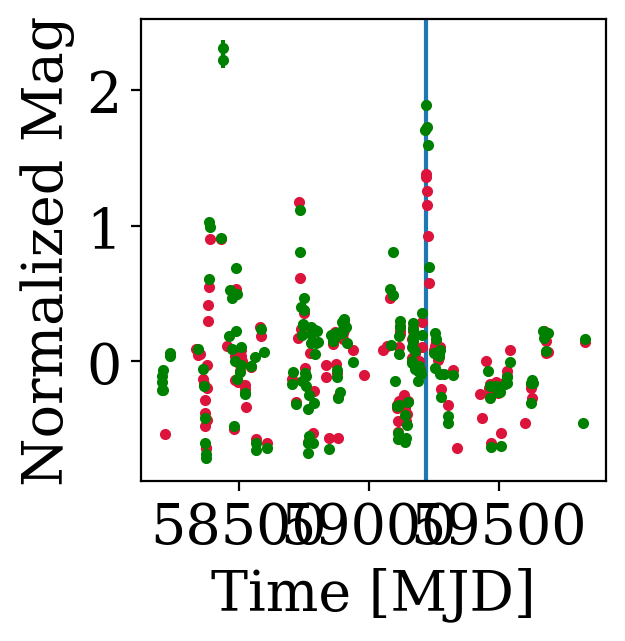

In [134]:
plt.figure(figsize=(3,3))
plt.errorbar(time, mag-np.median(mag), magerr, fmt='.', color='Crimson')
plt.errorbar(timeg, magg-np.median(magg), magerrg, fmt='.', color='green')
plt.axvline(loc)
plt.xlabel("Time [MJD]")
plt.ylabel("Normalized Mag")

In [16]:
# test should be nan because it's *not* a real dipper.
print (evaluate(lc['mjd_ztf_source'].values,
                   lc['mag_ztf_source'].values, 
                   lc['magerr_ztf_source'].values, 
                   lc['catflags_ztf_source'].values,
                   lc['band_ztf_source'], lc['ra_ztf_source'].values[0], 
        lc['dec_ztf_source'].values[0]))

Nphot                         2.400000e+02
biweight_scale                3.461178e-02
frac_above_2_sigma            4.166667e-02
Ndips                         1.000000e+00
rate                          6.132517e-04
chi2dof                       1.014158e+00
ADF_const                    -4.624648e-01
ADF_const_trend              -2.798006e+00
ADF_pval_const                8.991355e-01
ADF_pval_const_trend          1.976778e-01
skew                          9.245210e-01
kurtosis                      1.285840e+00
mad                           2.228355e-02
stetson_i                     1.064999e+03
stetson_j                     2.662099e+02
stetson_k                     7.631465e-01
invNeumann                    1.687574e+00
best_dip_power                3.844841e+00
best_dip_time_loc             5.980731e+04
best_dip_start                5.980121e+04
best_dip_end                  5.981320e+04
best_dip_dt                   0.000000e+00
best_dip_ndet                 4.000000e+00
best_dip_sc

## Full Search

In [8]:
# define my cols 
column_names = ['Nphot',
    'biweight_scale',
    'frac_above_2_sigma',
    'Ndips',
    'rate',
    'chi2dof',
    'ADF_const',
    'ADF_const_trend',
    'ADF_pval_const',
    'ADF_pval_const_trend',
    'skew', 
    'kurtosis',
    'mad',
    'stetson_i',
    'stetson_j',
    'stetson_k',
    'invNeumann',
    'best_dip_power',
    'best_dip_time_loc',
    'best_dip_start',
    'best_dip_end',
    'best_dip_dt',
    'best_dip_ndet',
    'best_dip_score',
    'left_error',
    'right_error',
    'chi_square_gp',
    'gp_fun',
    'gp_status',
    'separation_btw_peaks',
    'closest_bright_star_arcsec',
    'closest_bright_star_mag',
    'closest_star_arcsec',
    'closest_star_mag',
    'density_arcsec2']

# Define DataFrame with loc and scale as meta
my_meta = pd.DataFrame(columns=column_names, dtype=float)

In [9]:
%%time
# apply calc_biweight function
calc_ = ens.batch(
    evaluate,
    'mjd_ztf_source', 'mag_ztf_source', 
    'magerr_ztf_source', 'catflags_ztf_source',
    'band_ztf_source', 'ra_ztf_source', 
    'dec_ztf_source',
    meta=my_meta,
    use_map=True)

Using generated label, result_1, for a batch result.
CPU times: user 533 ms, sys: 63.3 ms, total: 596 ms
Wall time: 589 ms


In [10]:
%%time
ens.object.join(calc_).update_ensemble()

CPU times: user 4.54 s, sys: 569 ms, total: 5.11 s
Wall time: 5.19 s


In [ ]:
%%time
full_table = ens.object.compute() # full table compute

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 144.12 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [ ]:
%%time
demo_table = ens.object.head(250_000, npartitions=10_000)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 22.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [186]:
q = (demo_table['Ndips']>0) & (demo_table['best_dip_ndet']>3)

In [188]:
len(demo_table[q]['best_dip_time_loc'])

25

In [189]:
def plot_lc(_id, loc):
    lc = ens.source.loc[_id]
    lc = lc.compute()
    th = lc.head(1)
    print (th['ra_gaia_andy_fg_dwarfs'], th['dec_gaia_andy_fg_dwarfs'])

    time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                       lc['mag_ztf_source'].values, 
                       lc['magerr_ztf_source'].values, 
                       lc['catflags_ztf_source'].values,
                       lc['band_ztf_source'].values, band_of_study='r', flag_good=0)

    timeg, magg, magerrg = my_tools.prepare_lc(lc['mjd_ztf_source'].values,
                       lc['mag_ztf_source'].values, 
                       lc['magerr_ztf_source'].values, 
                       lc['catflags_ztf_source'].values,
                       lc['band_ztf_source'].values, band_of_study='g', flag_good=0)

    plt.figure()
    plt.errorbar(time, mag, magerr, fmt='-o', color='Crimson')
    plt.errorbar(timeg, magg, magerrg, fmt='-o', color='green')

    plt.xlabel("Time [MJD]")
    plt.ylabel("Magnitude")

    plt.axvline(loc)

    plt.ylim(plt.ylim()[::-1])

In [182]:
tc = 0
for i, j in tqdm(zip(demo_table[q]['best_dip_time_loc'], demo_table[q].index.values)):
    print ("Count index:", tc)
    print (j, i)
    tc+=1

17it [00:00, 12568.86it/s]

Count index: 0
214833630155898880 58370.41837
Count index: 1
349501193262727168 59816.47397
Count index: 2
352191967087558656 59223.24518
Count index: 3
366012772284104704 58487.26439
Count index: 4
377174417102340096 58365.50593
Count index: 5
378629381460852736 59689.17172
Count index: 6
389296206100037632 58370.49113
Count index: 7
391062914590572544 59219.26408
Count index: 8
393852297223864320 58875.21997
Count index: 9
393869823529975808 58875.21999
Count index: 10
393891728140009472 58882.14278
Count index: 11
393999705748537344 58750.48503
Count index: 12
394003811724689408 58735.5085
Count index: 13
394162237763223552 58376.51078
Count index: 14
466548498855100416 58837.25449
Count index: 15
499393348491018240 58508.22031
Count index: 16
513263658973790208 58373.49371


0it [00:00, ?it/s]/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
1it [00:12, 12.06s/it]

_hipscat_index
214833630155898880    32.300625
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
214833630155898880    27.839565
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2it [00:27, 14.06s/it]

_hipscat_index
349501193262727168    69.142275
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
349501193262727168    35.792187
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
3it [00:43, 14.78s/it]

_hipscat_index
352191967087558656    64.658024
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
352191967087558656    34.828519
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
4it [00:54, 13.54s/it]

_hipscat_index
366012772284104704    83.511686
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
366012772284104704    34.959714
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
5it [01:10, 14.29s/it]

_hipscat_index
375310573446889472    81.334989
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
375310573446889472    38.813459
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
6it [01:25, 14.40s/it]

_hipscat_index
377174417102340096    77.287698
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
377174417102340096    40.099766
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
7it [01:37, 13.82s/it]

_hipscat_index
378624580723408896    85.035515
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
378624580723408896    36.764737
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
8it [01:54, 14.76s/it]

_hipscat_index
378629381460852736    84.86072
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
378629381460852736    36.795529
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
9it [02:06, 13.88s/it]

_hipscat_index
389296206100037632    83.180749
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
389296206100037632    42.134971
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
10it [02:21, 14.38s/it]

_hipscat_index
391062914590572544    84.116859
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
391062914590572544    43.405593
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
11it [02:37, 14.83s/it]

_hipscat_index
393852297223864320    89.083765
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
393852297223864320    45.684106
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
12it [02:49, 13.92s/it]

_hipscat_index
393869823529975808    89.442633
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
393869823529975808    45.669346
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
13it [03:05, 14.48s/it]

_hipscat_index
393891728140009472    89.313155
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
393891728140009472    45.688713
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
14it [03:19, 14.51s/it]

_hipscat_index
393999705748537344    89.446583
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
393999705748537344    45.930415
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
15it [03:31, 13.69s/it]

_hipscat_index
394003811724689408    89.291086
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
394003811724689408    45.924093
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
16it [03:47, 14.41s/it]

_hipscat_index
394162237763223552    85.2961
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
394162237763223552    44.166758
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
17it [04:02, 14.46s/it]

_hipscat_index
394182263685775360    84.847747
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
394182263685775360    44.206548
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
18it [04:15, 14.10s/it]

_hipscat_index
429995186139955200    88.565683
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
429995186139955200    52.034904
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
19it [04:31, 14.49s/it]

_hipscat_index
433929782489513984    57.844229
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
433929782489513984    32.686114
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
20it [04:43, 13.78s/it]

_hipscat_index
466548498855100416    61.798953
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
466548498855100416    44.742578
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/tmp/ipykernel_85231/881428140.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
21it [04:57, 13.84s/it]

_hipscat_index
466813763140452352    61.239858
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
466813763140452352    45.140886
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
22it [05:11, 14.09s/it]

_hipscat_index
483051564215304192    52.235845
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
483051564215304192    43.780079
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
23it [05:23, 13.30s/it]

_hipscat_index
499393348491018240    54.091858
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
499393348491018240    49.459464
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
24it [05:37, 13.47s/it]

_hipscat_index
508117579458412544    70.38897
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
508117579458412544    46.271986
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.87 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
25it [05:50, 14.04s/it]

_hipscat_index
513263658973790208    75.968878
Name: ra_gaia_andy_fg_dwarfs, dtype: float64 _hipscat_index
513263658973790208    50.669566
Name: dec_gaia_andy_fg_dwarfs, dtype: float64


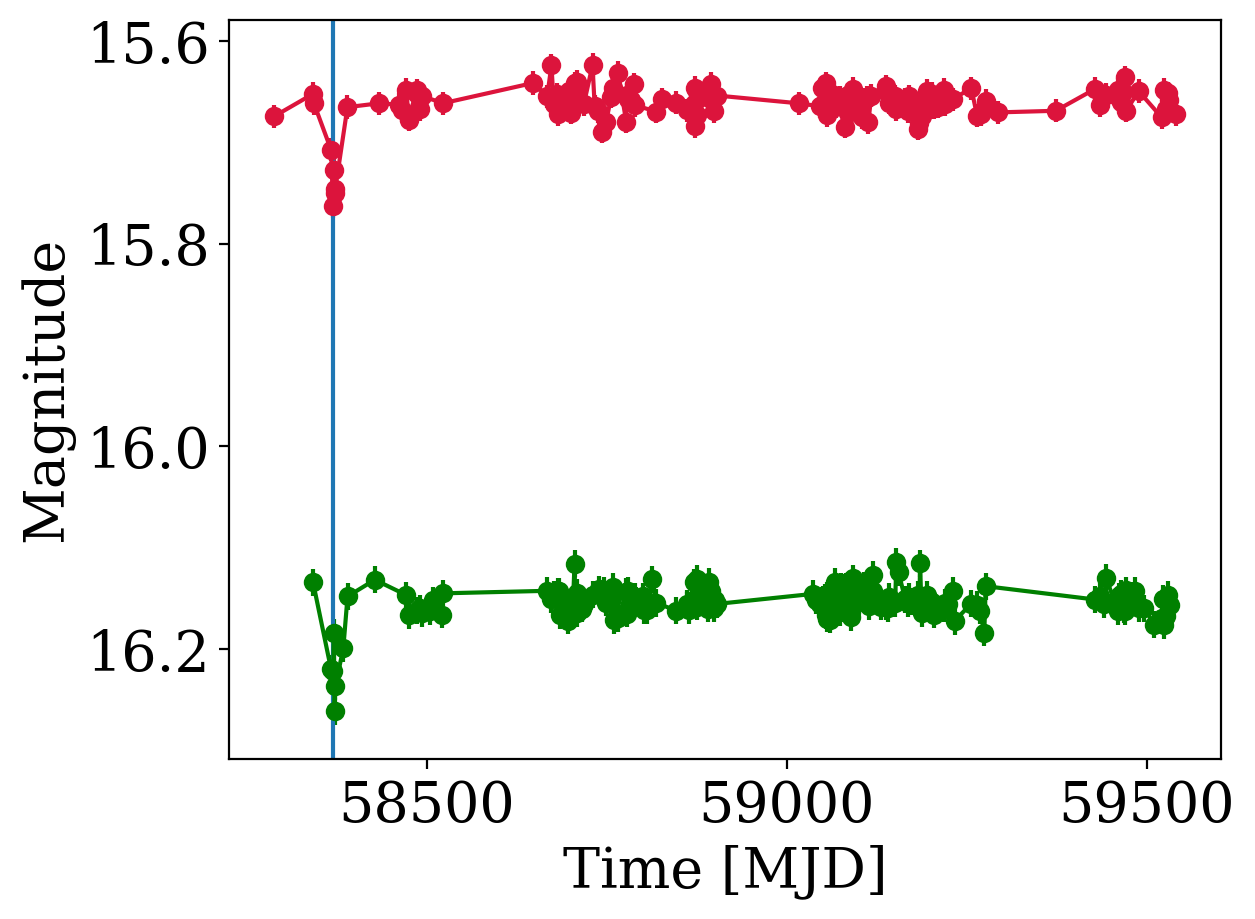

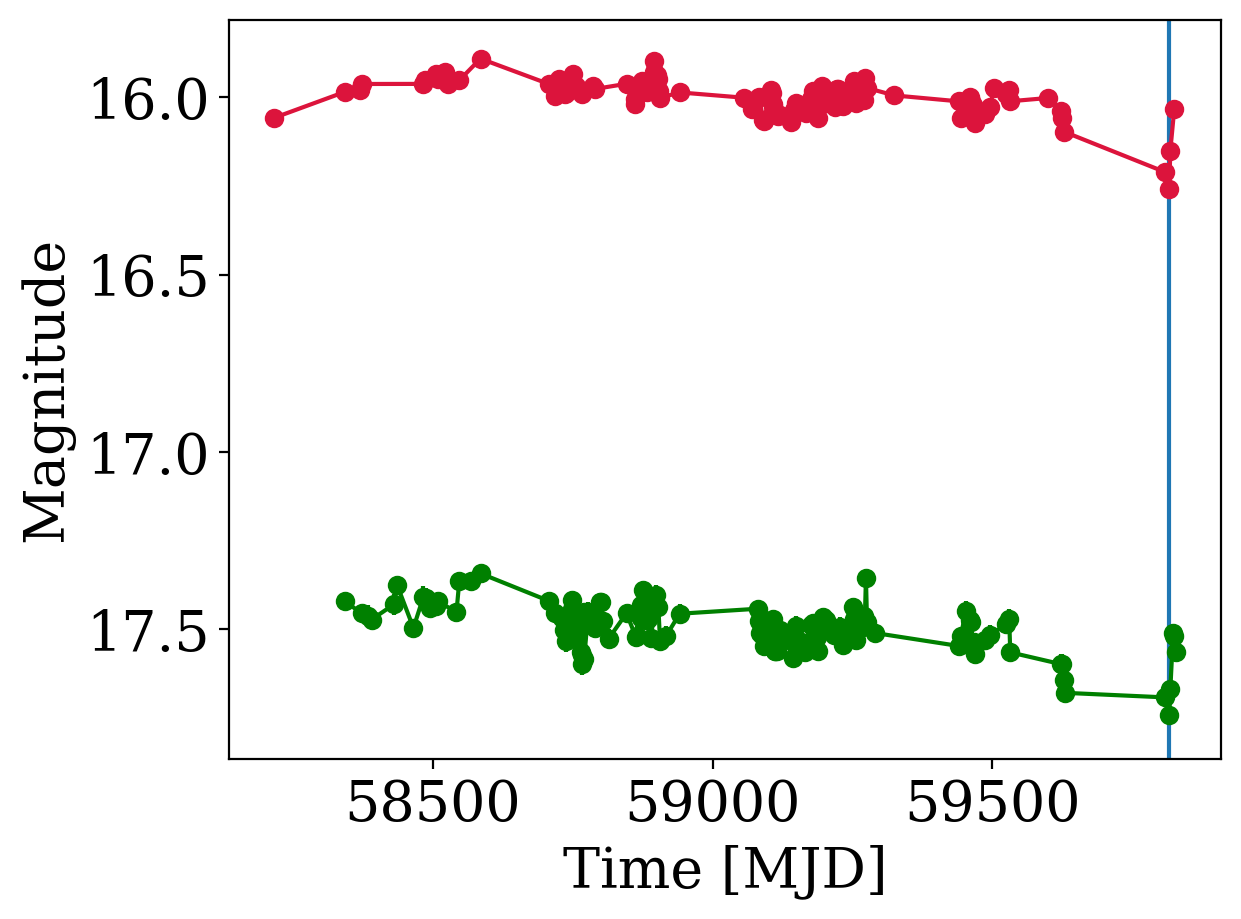

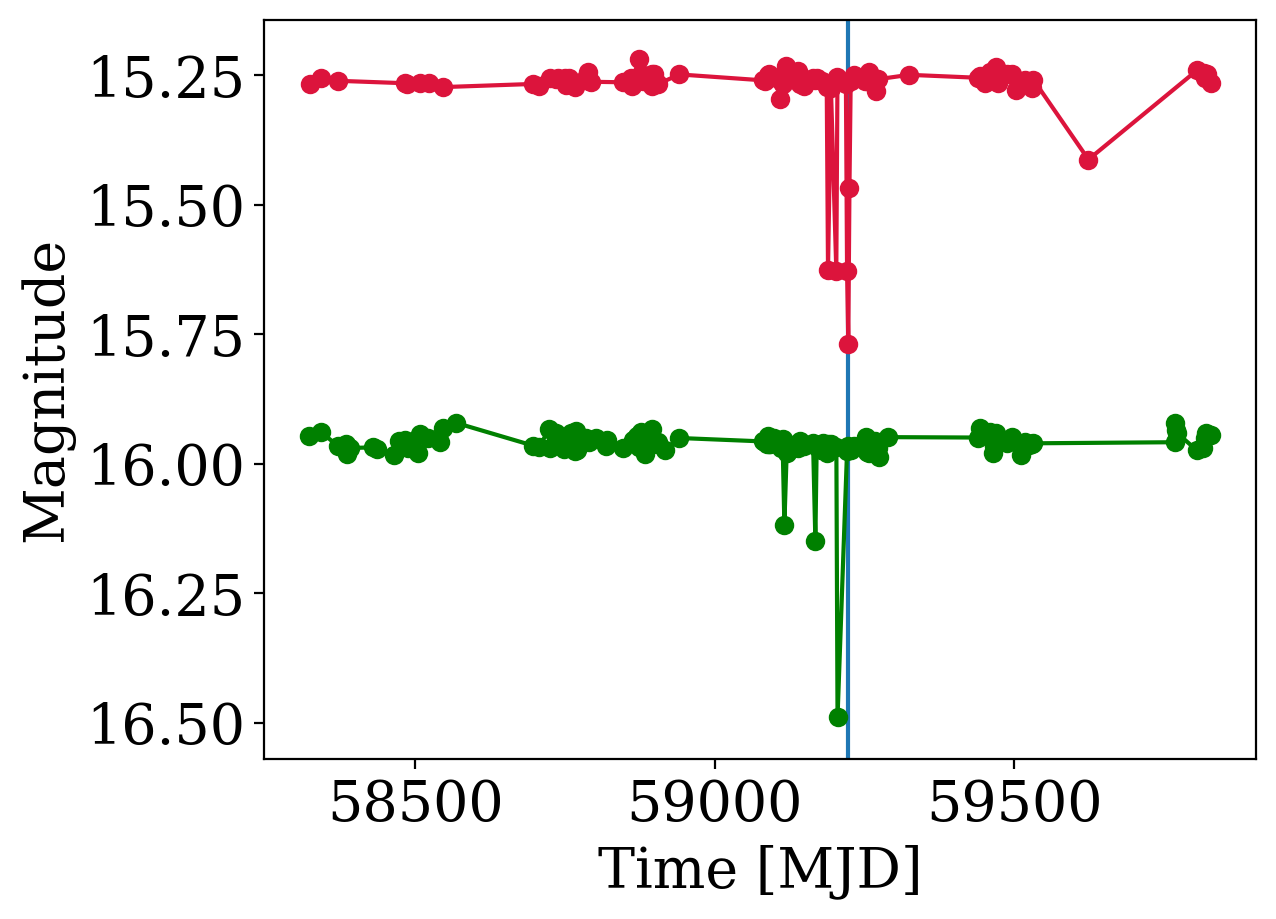

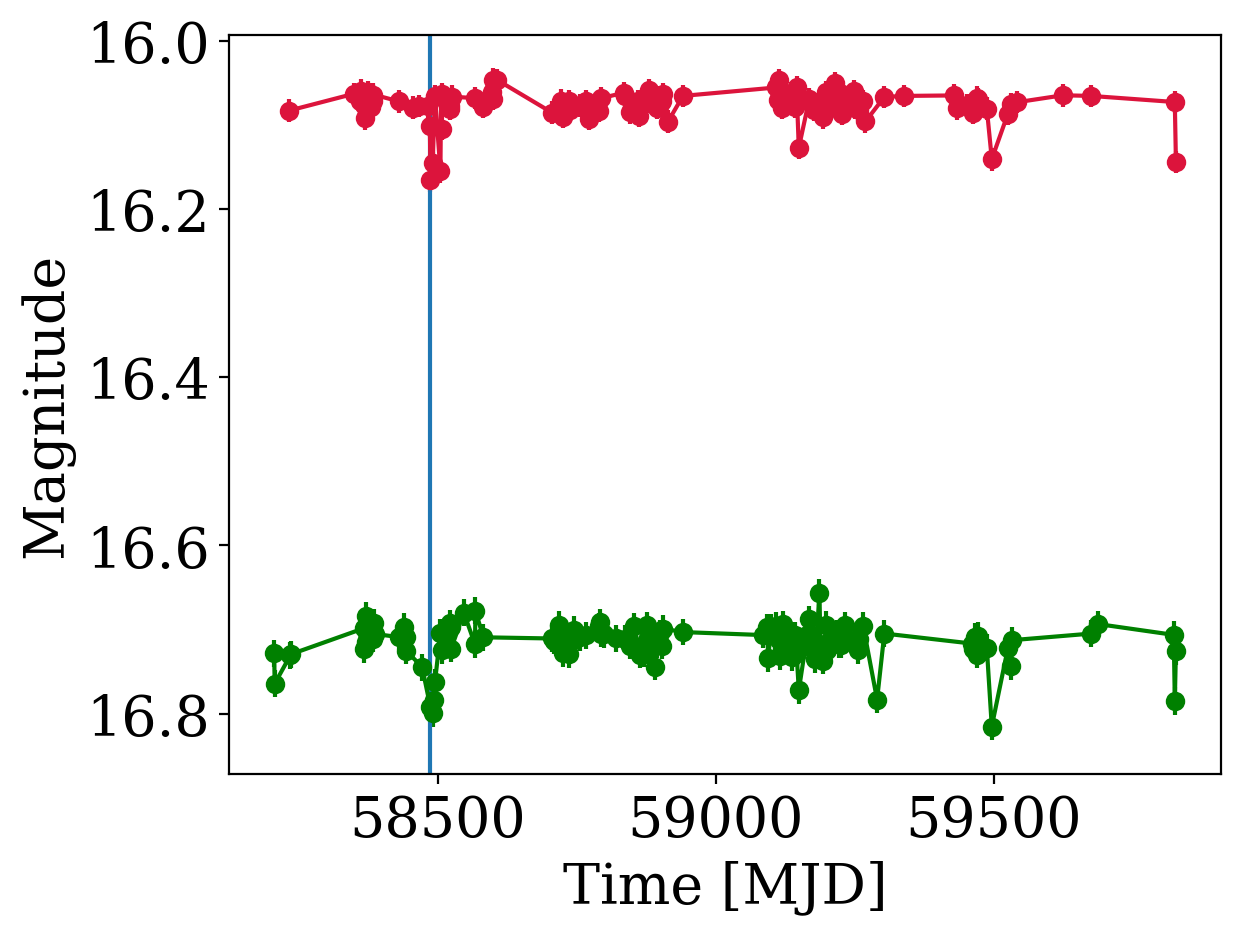

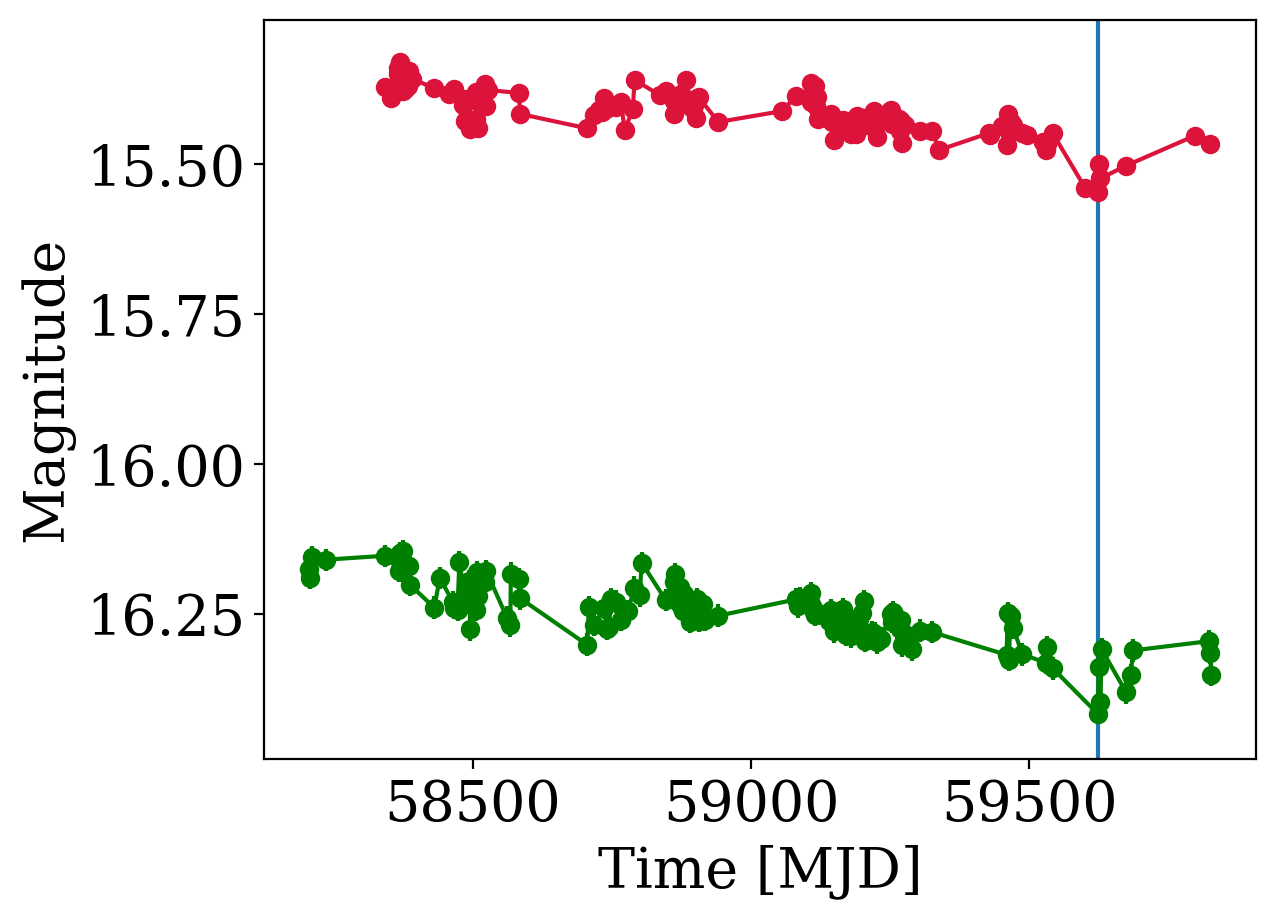

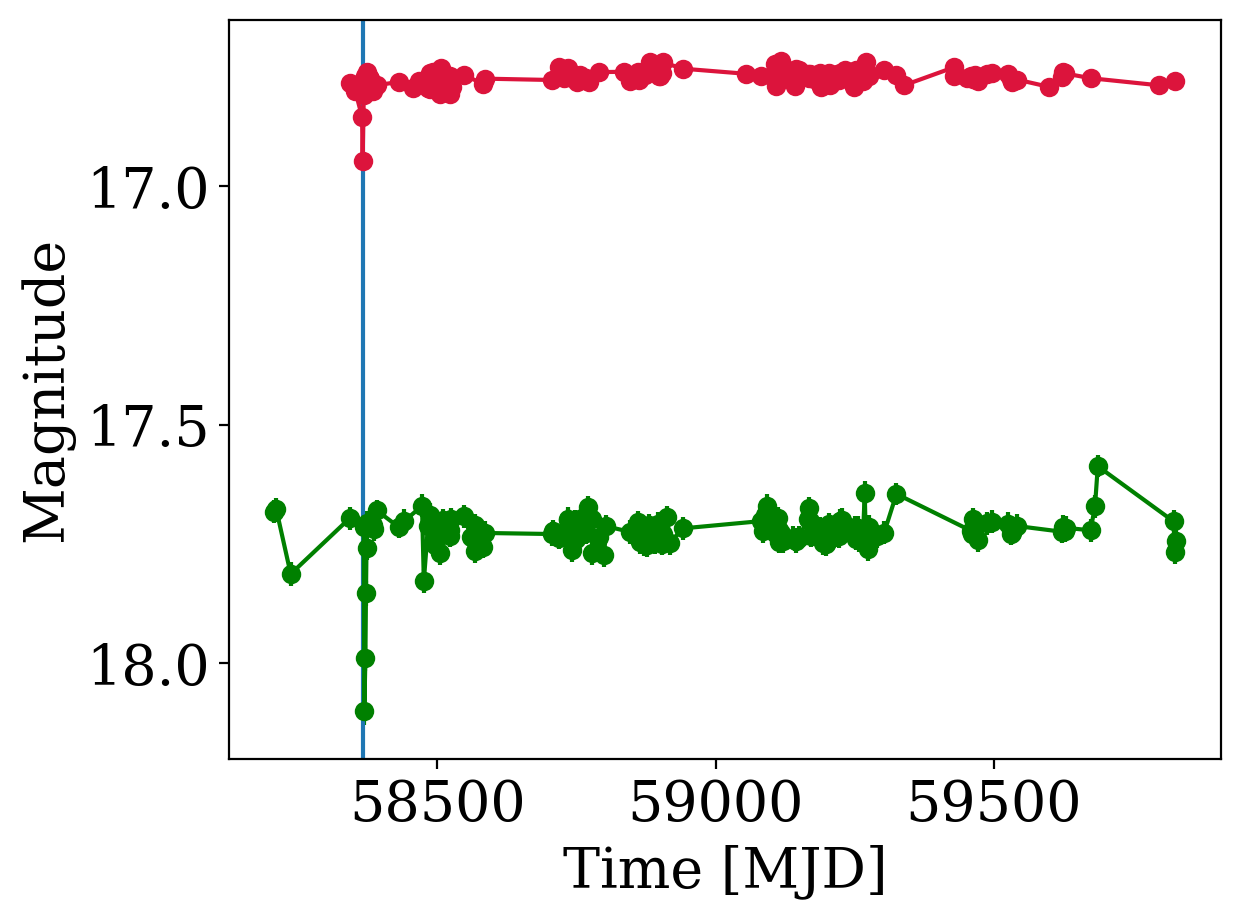

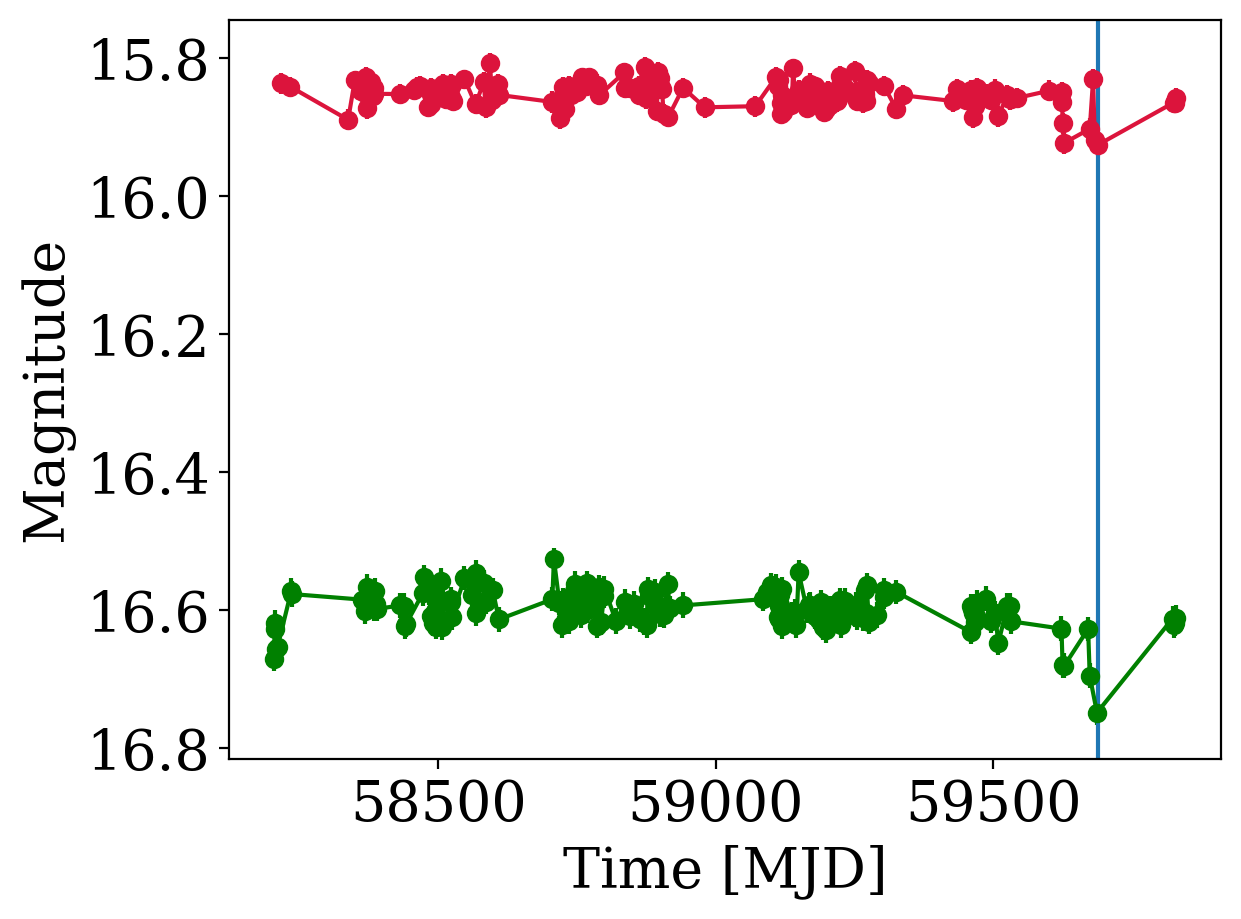

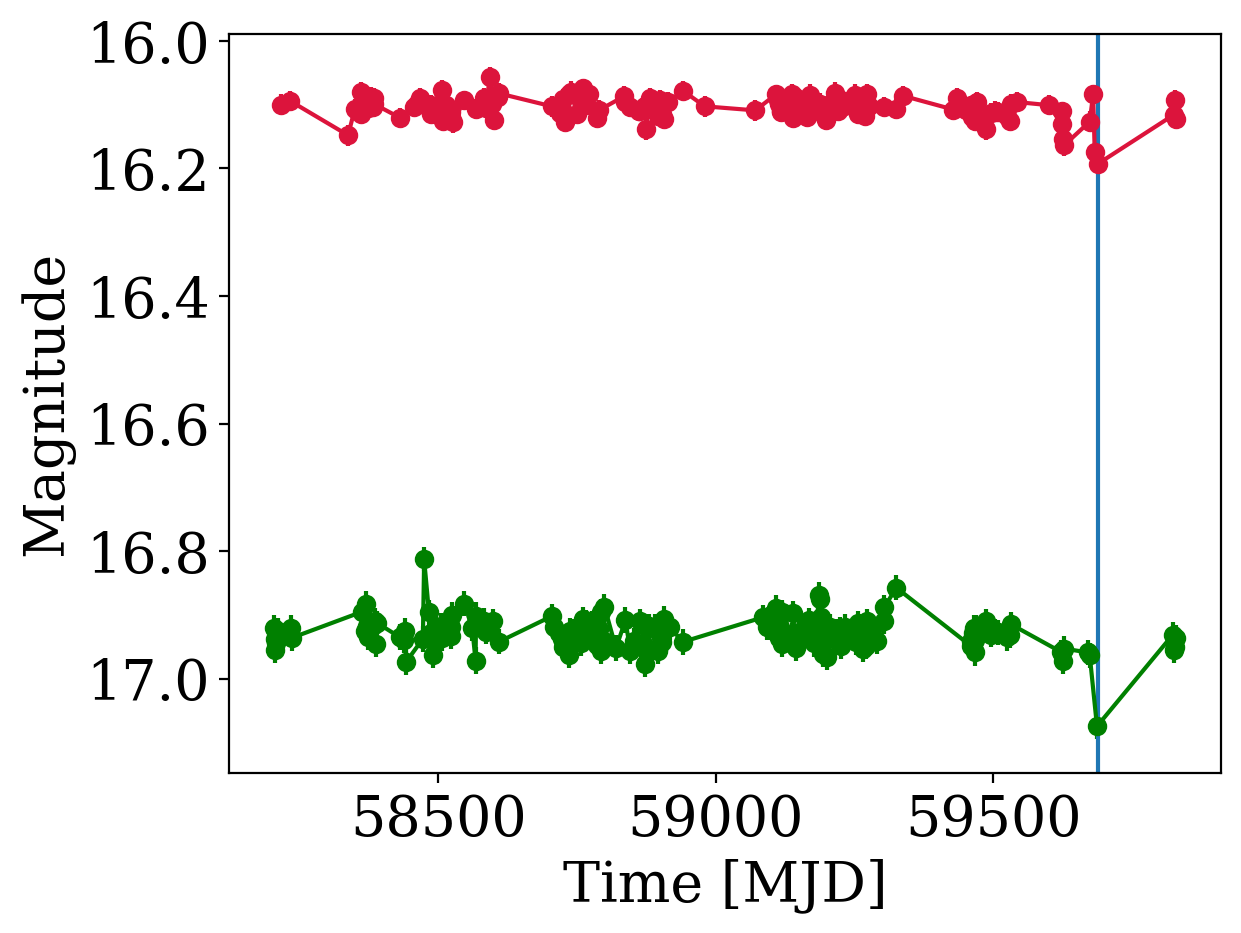

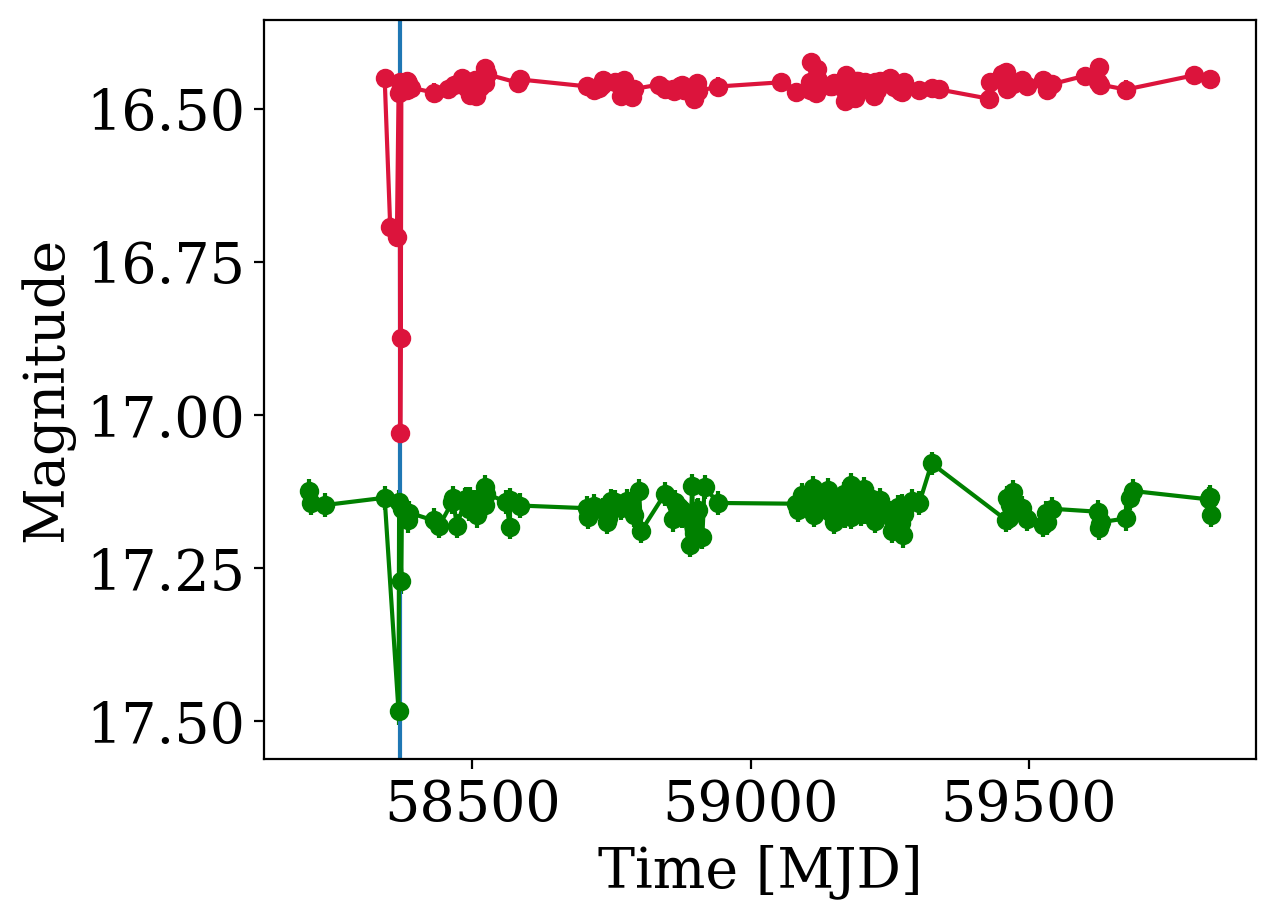

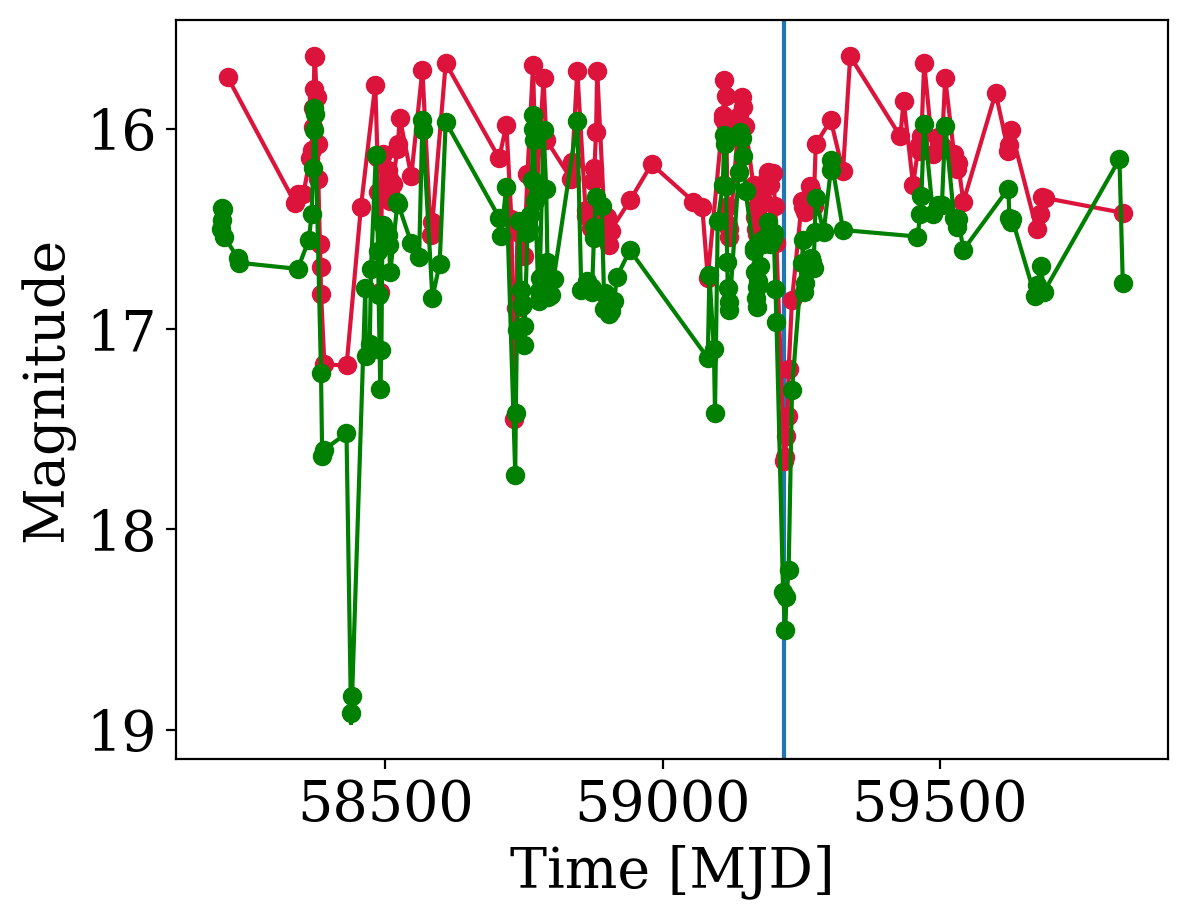

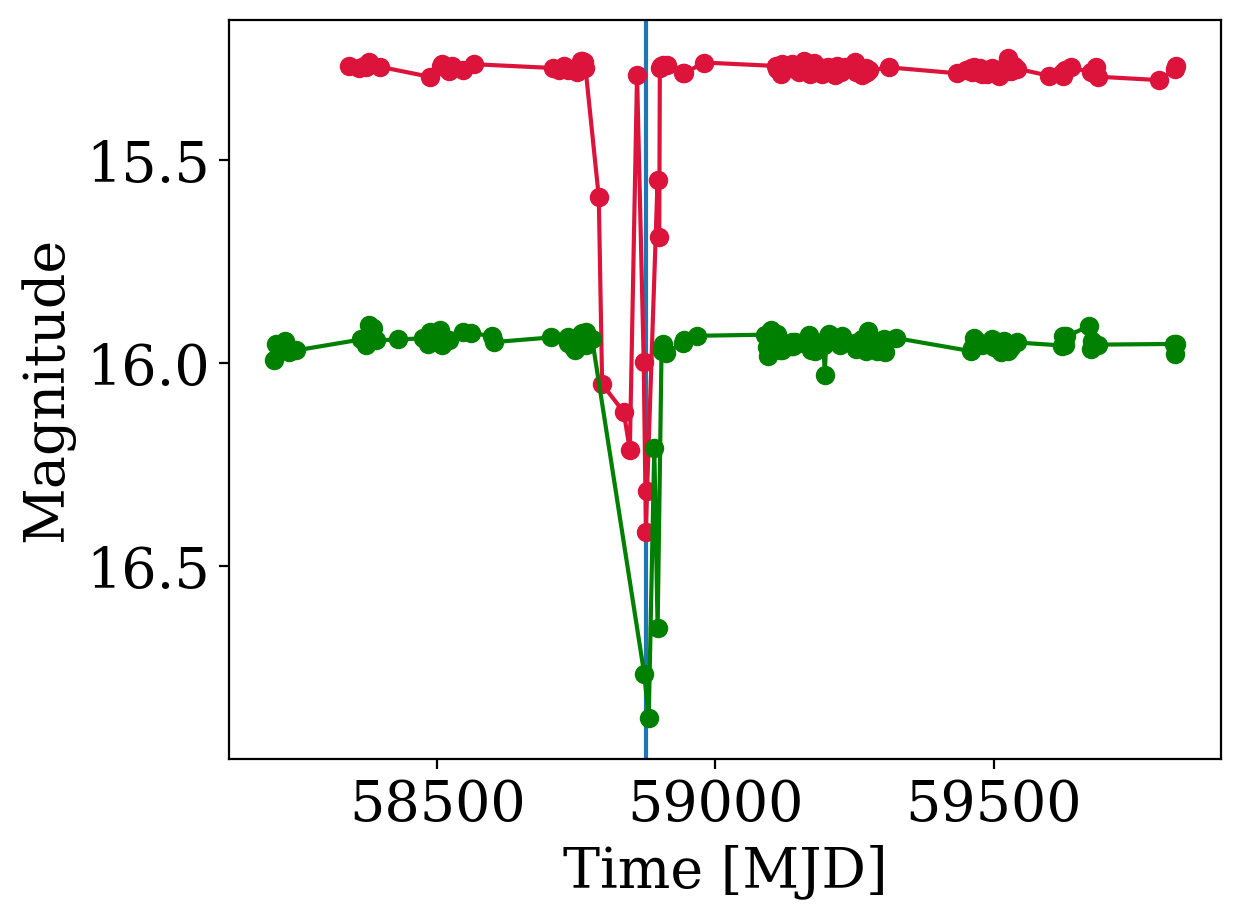

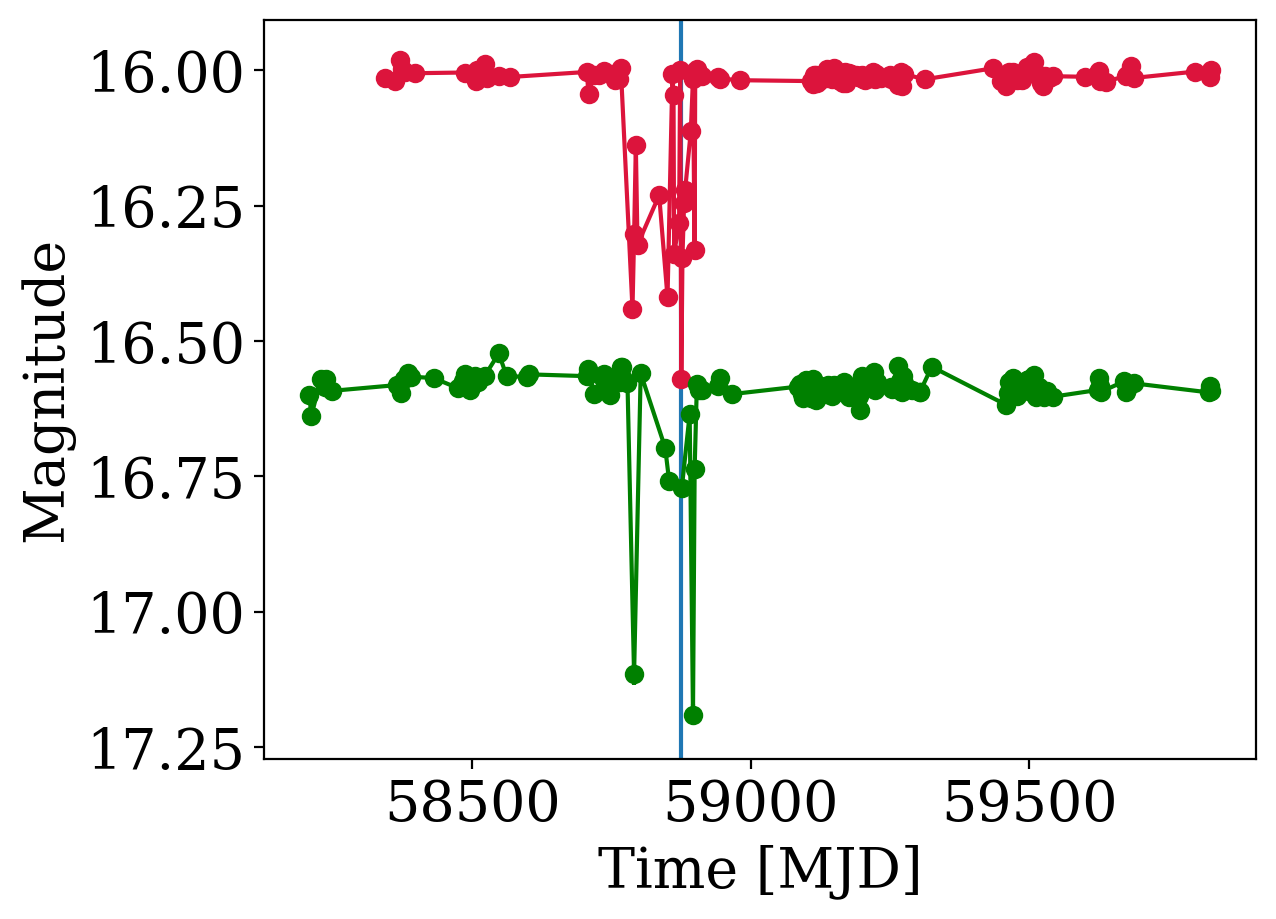

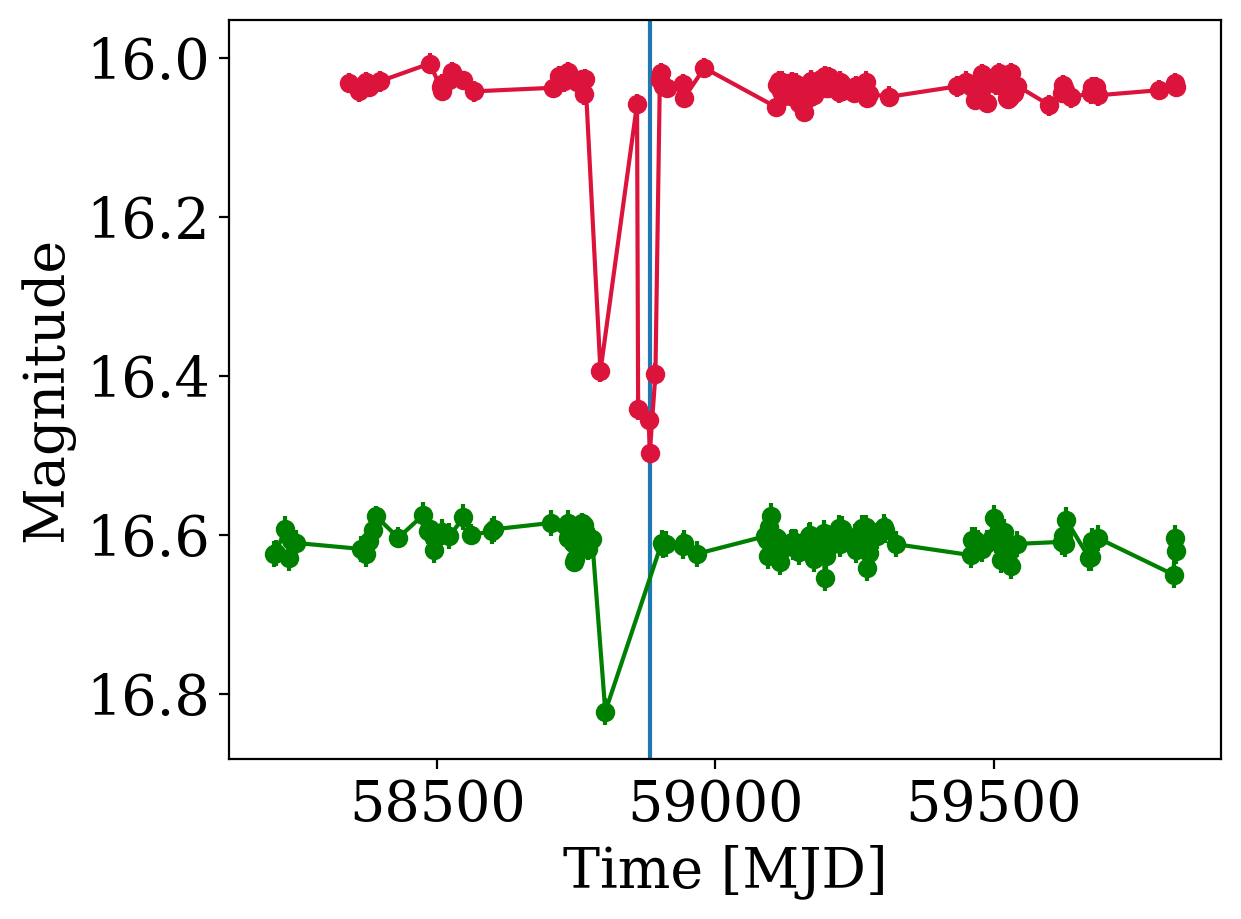

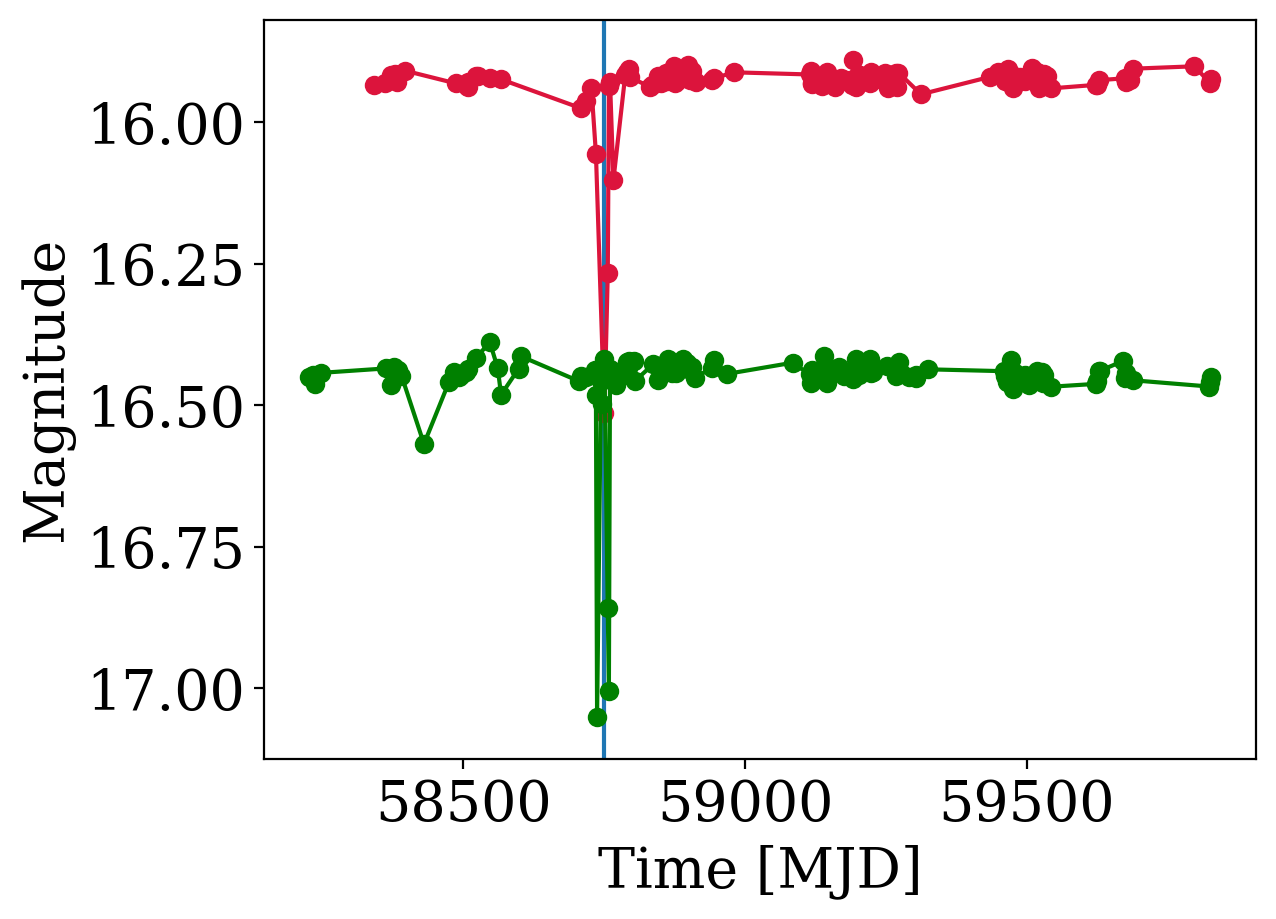

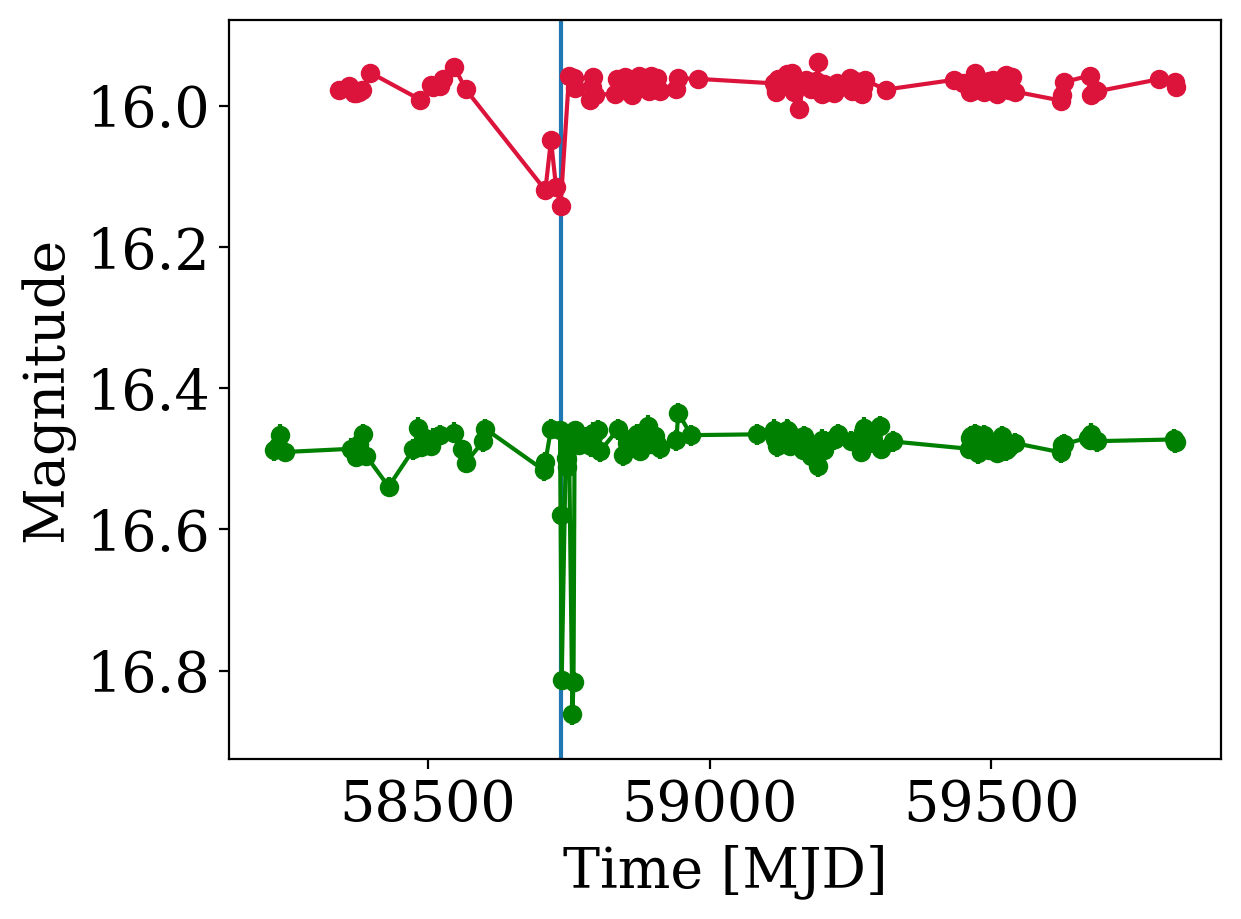

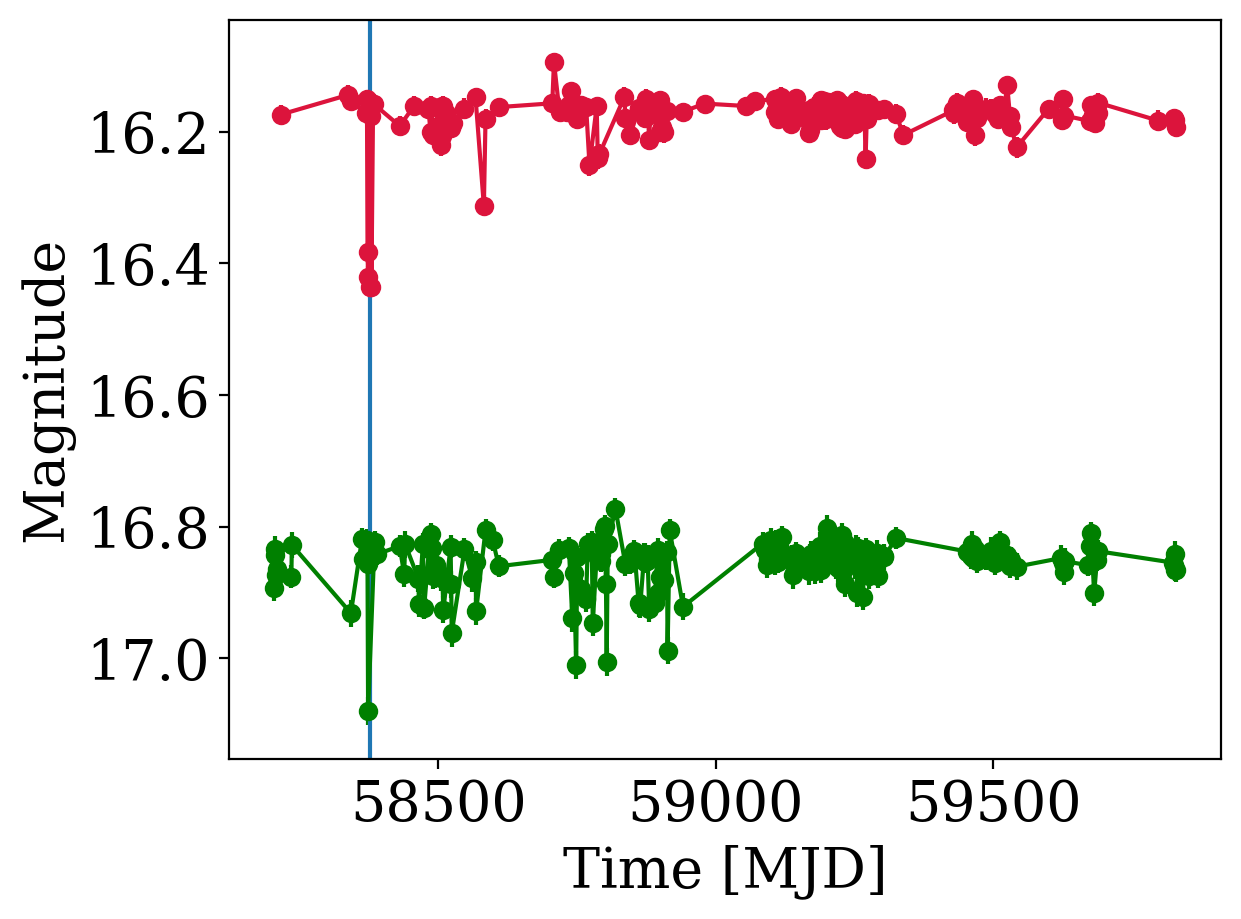

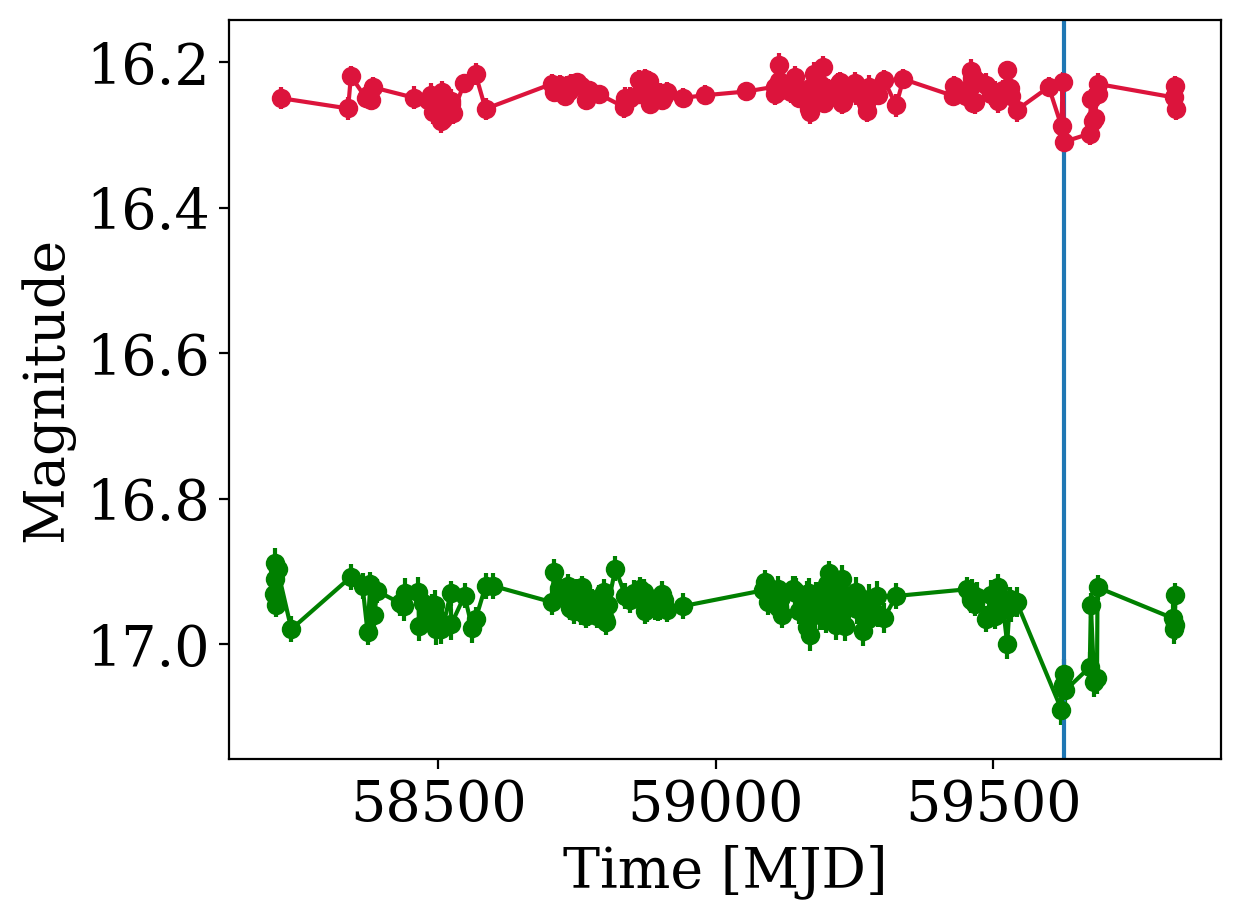

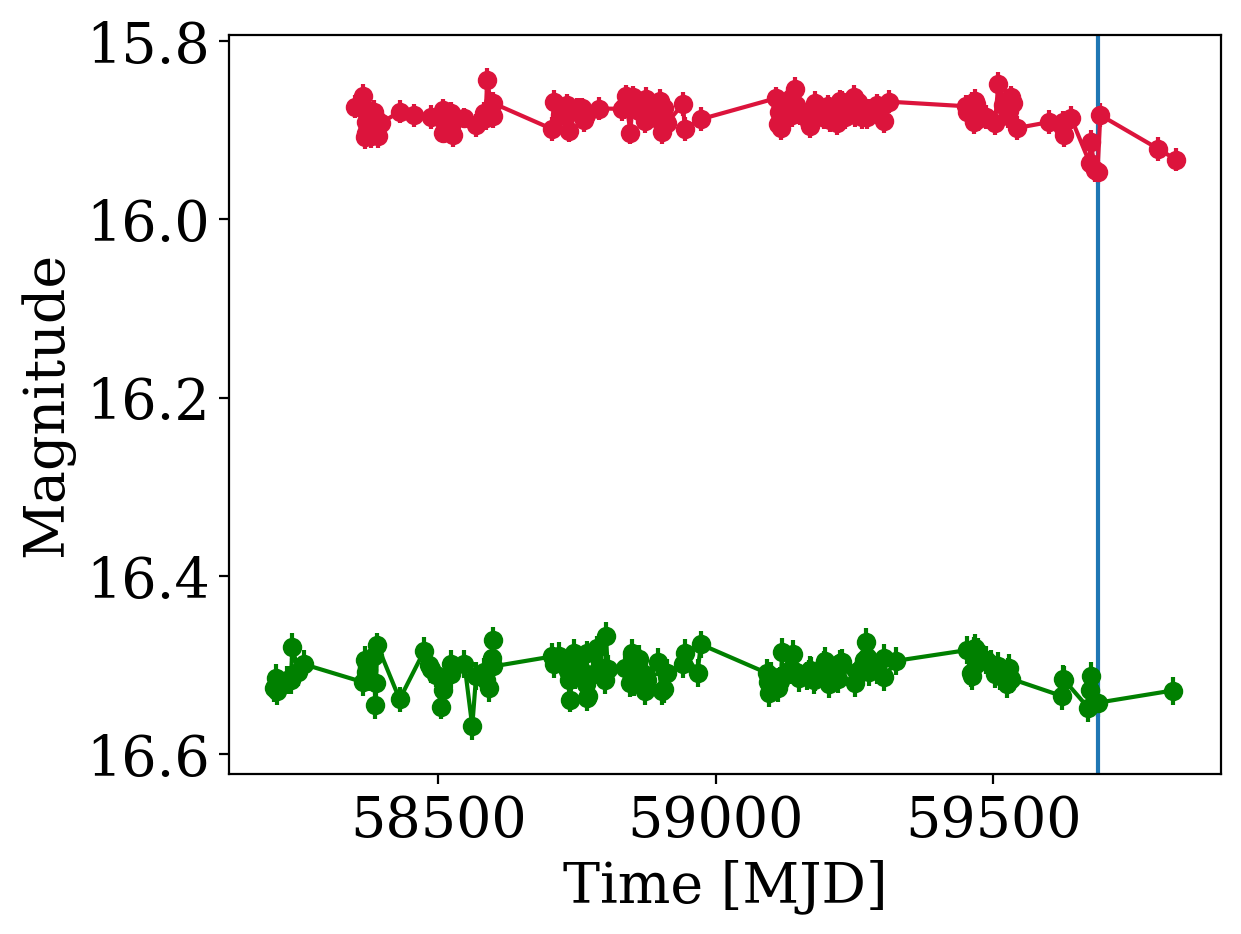

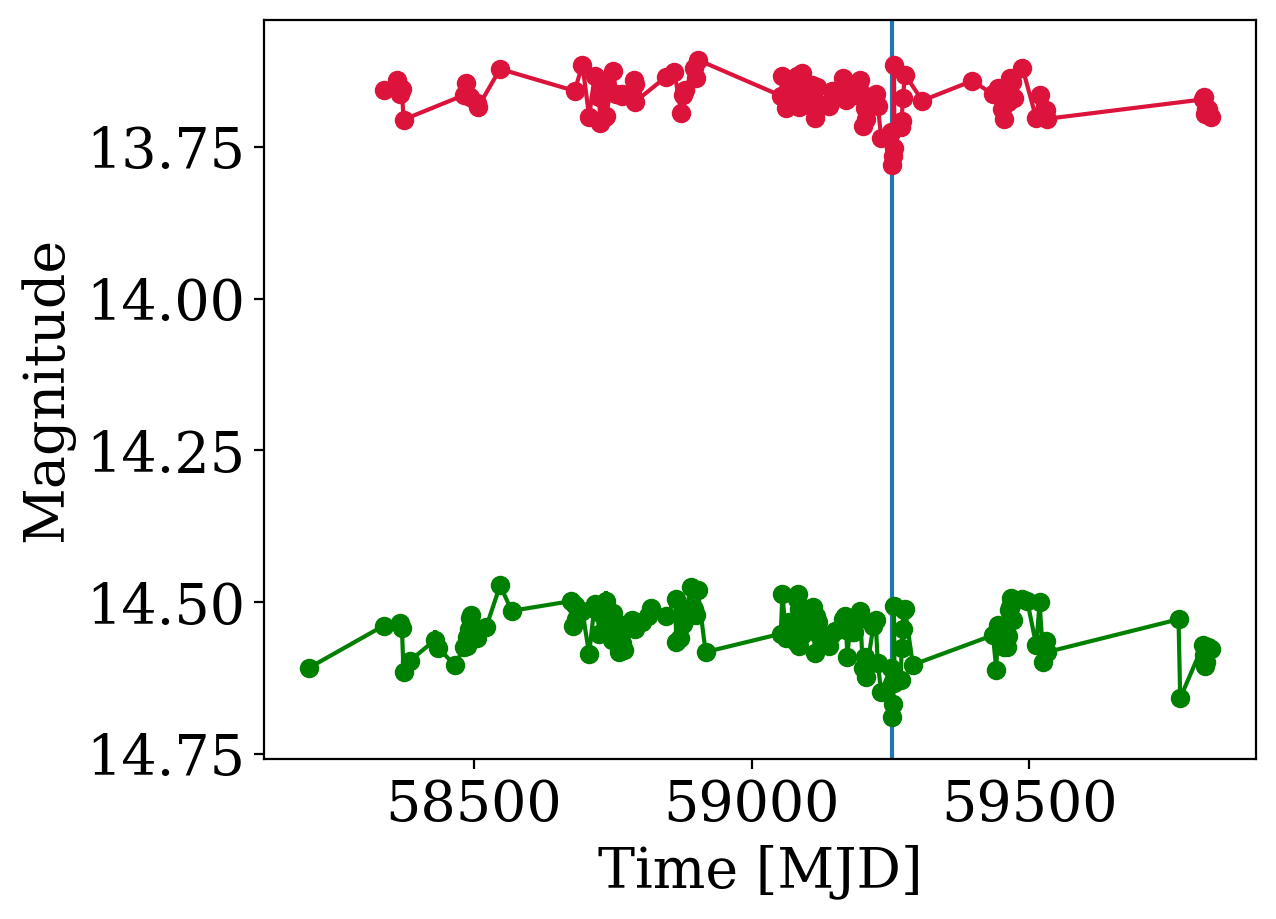

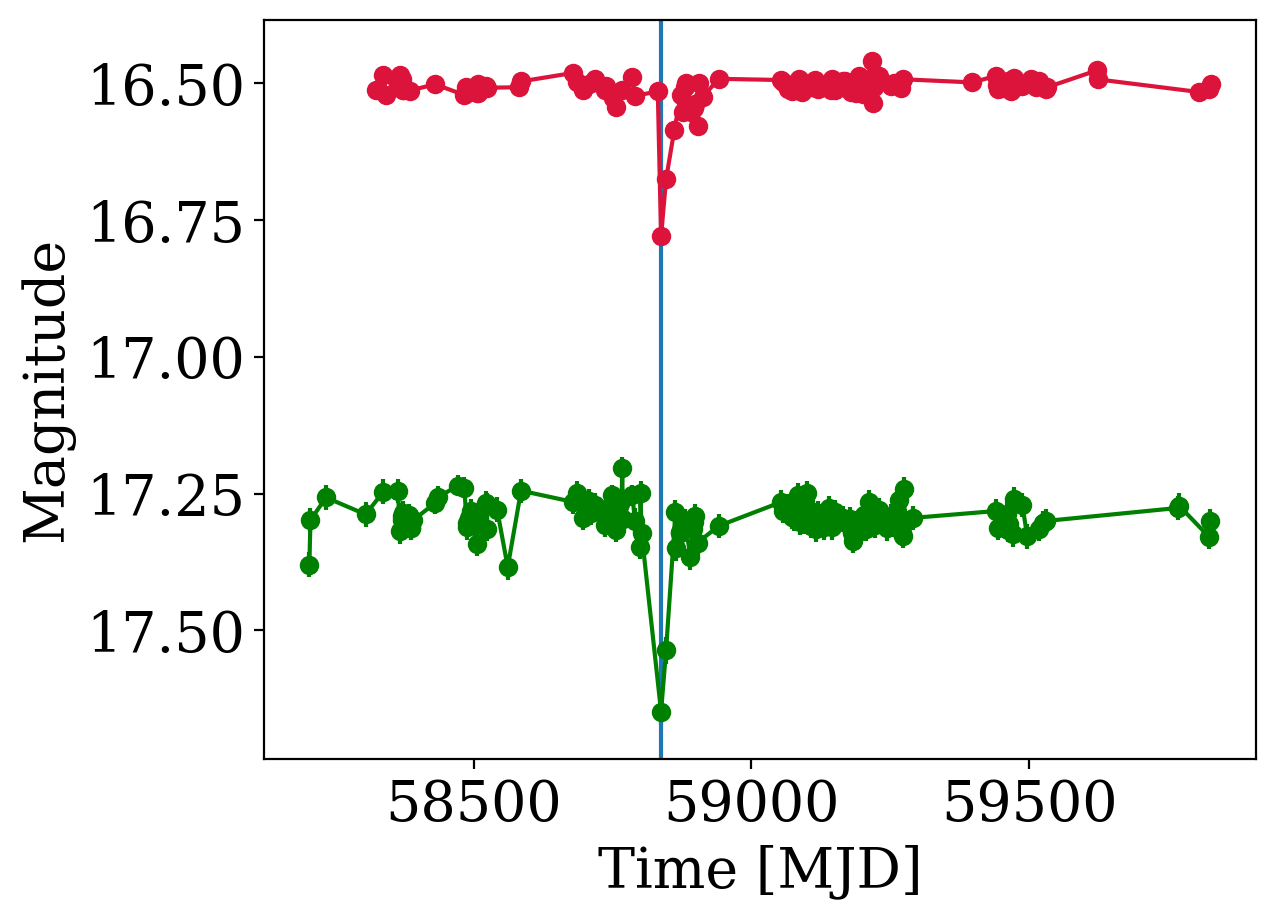

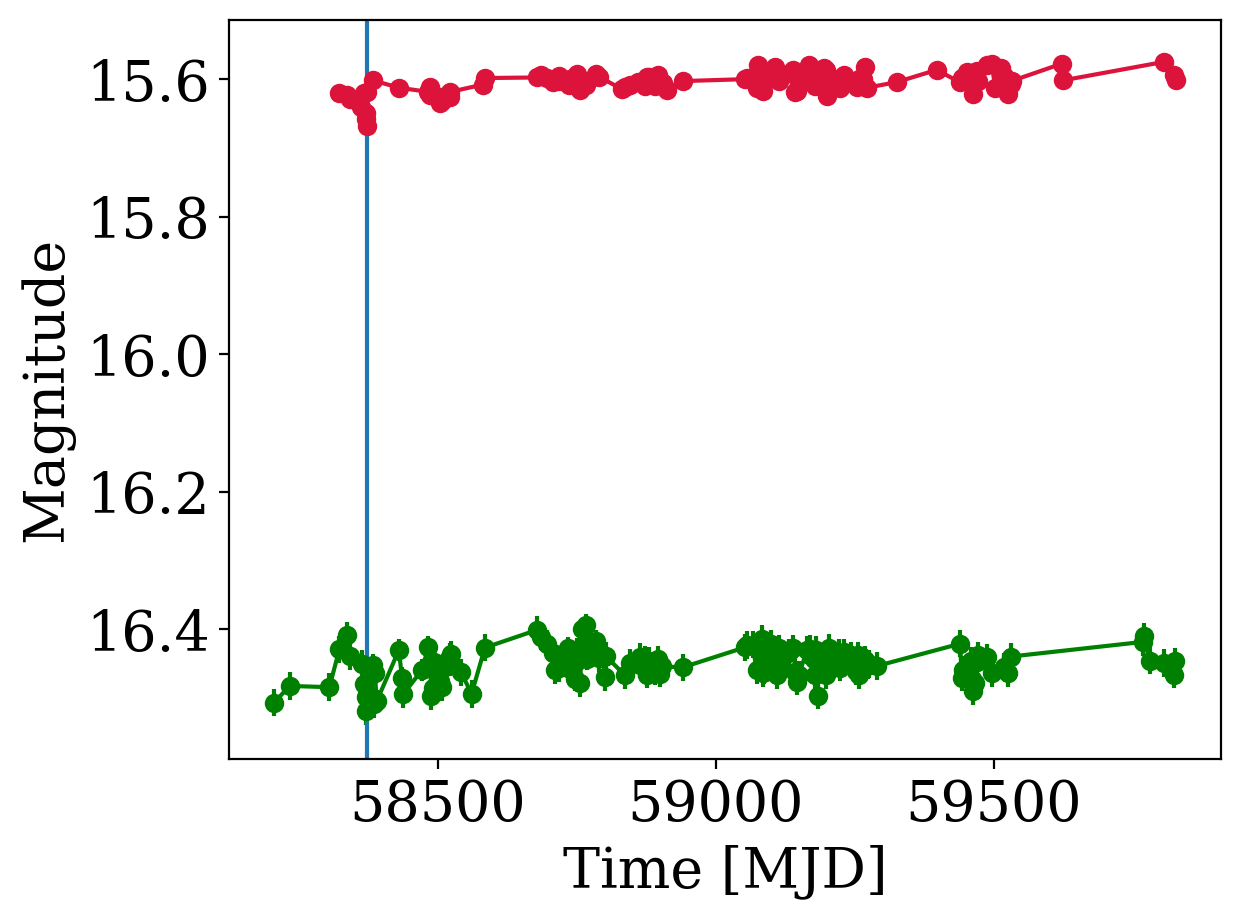

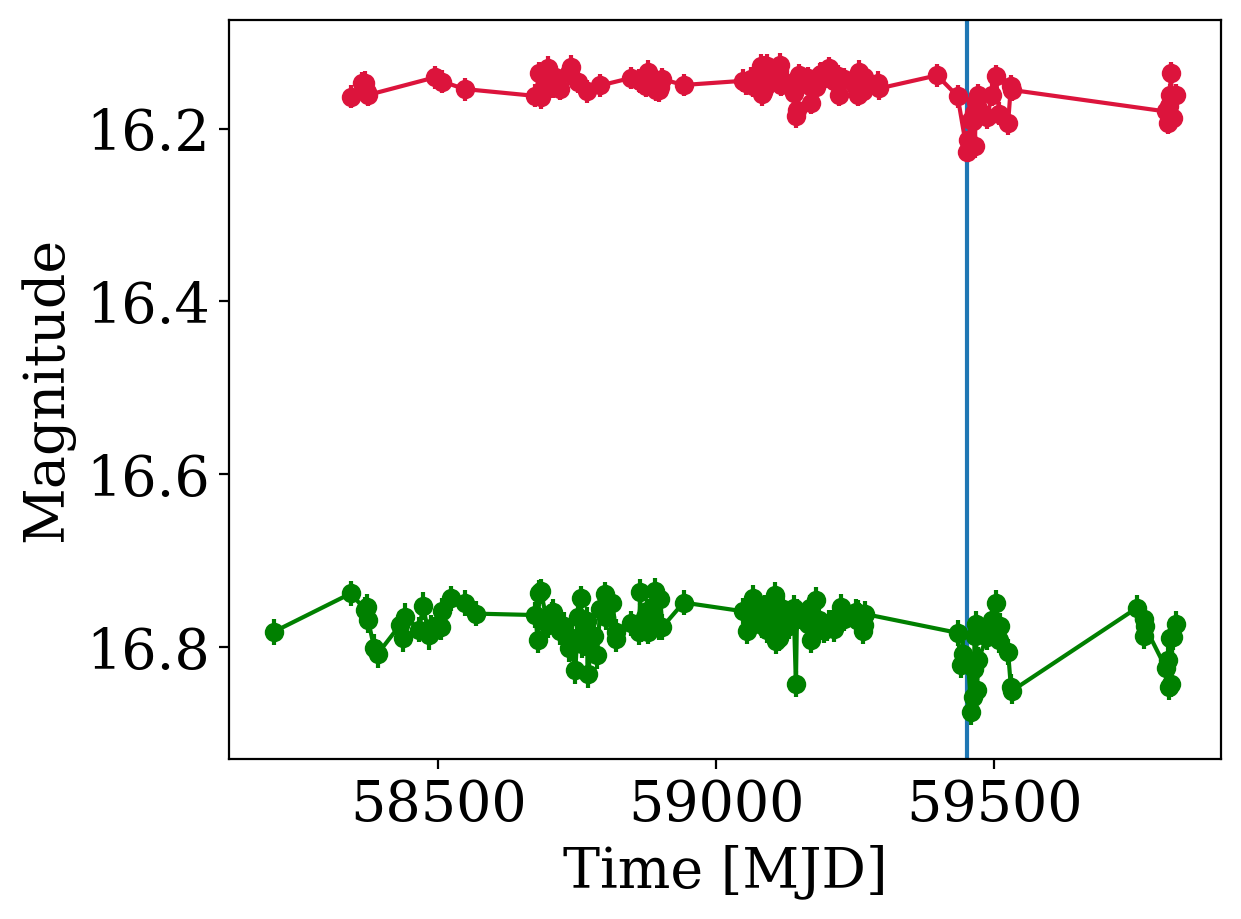

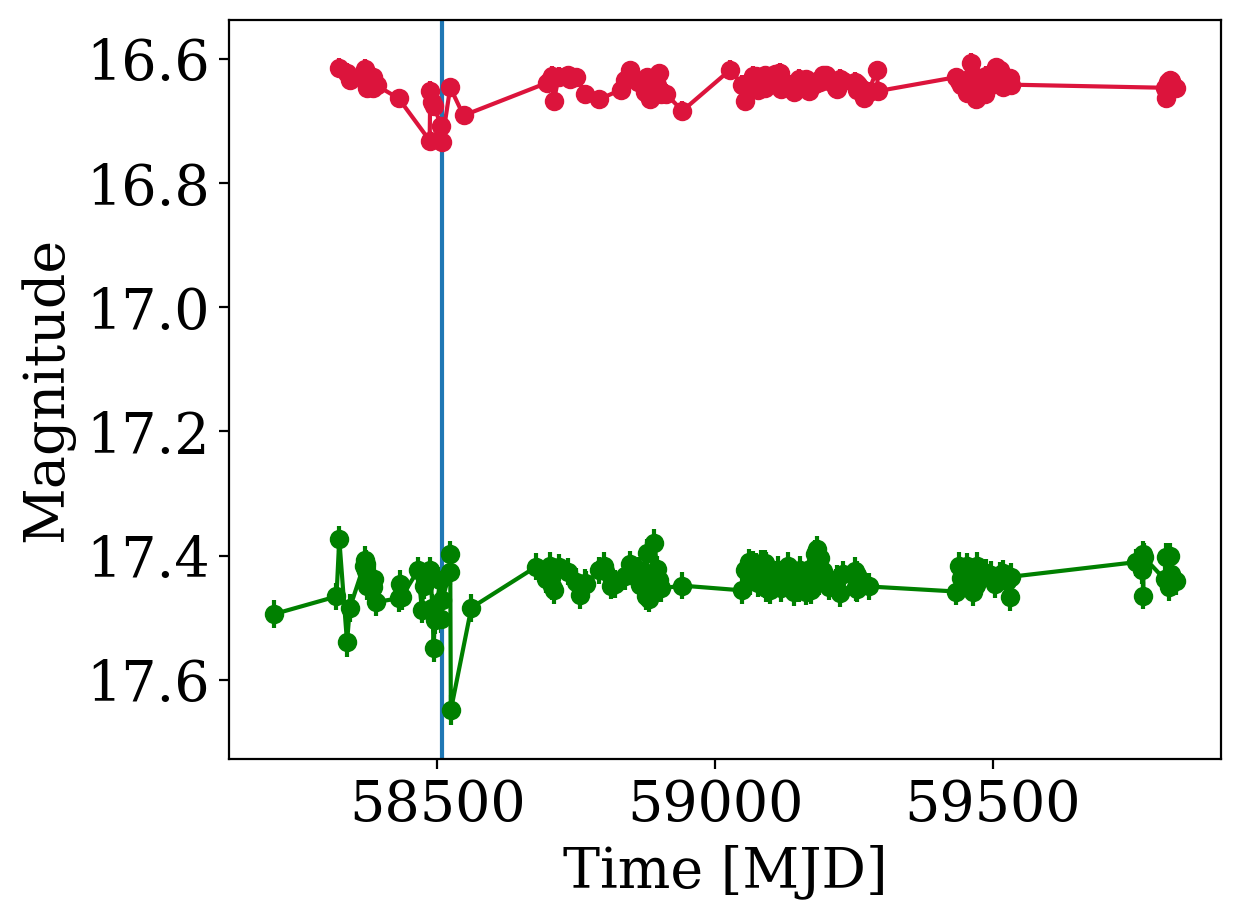

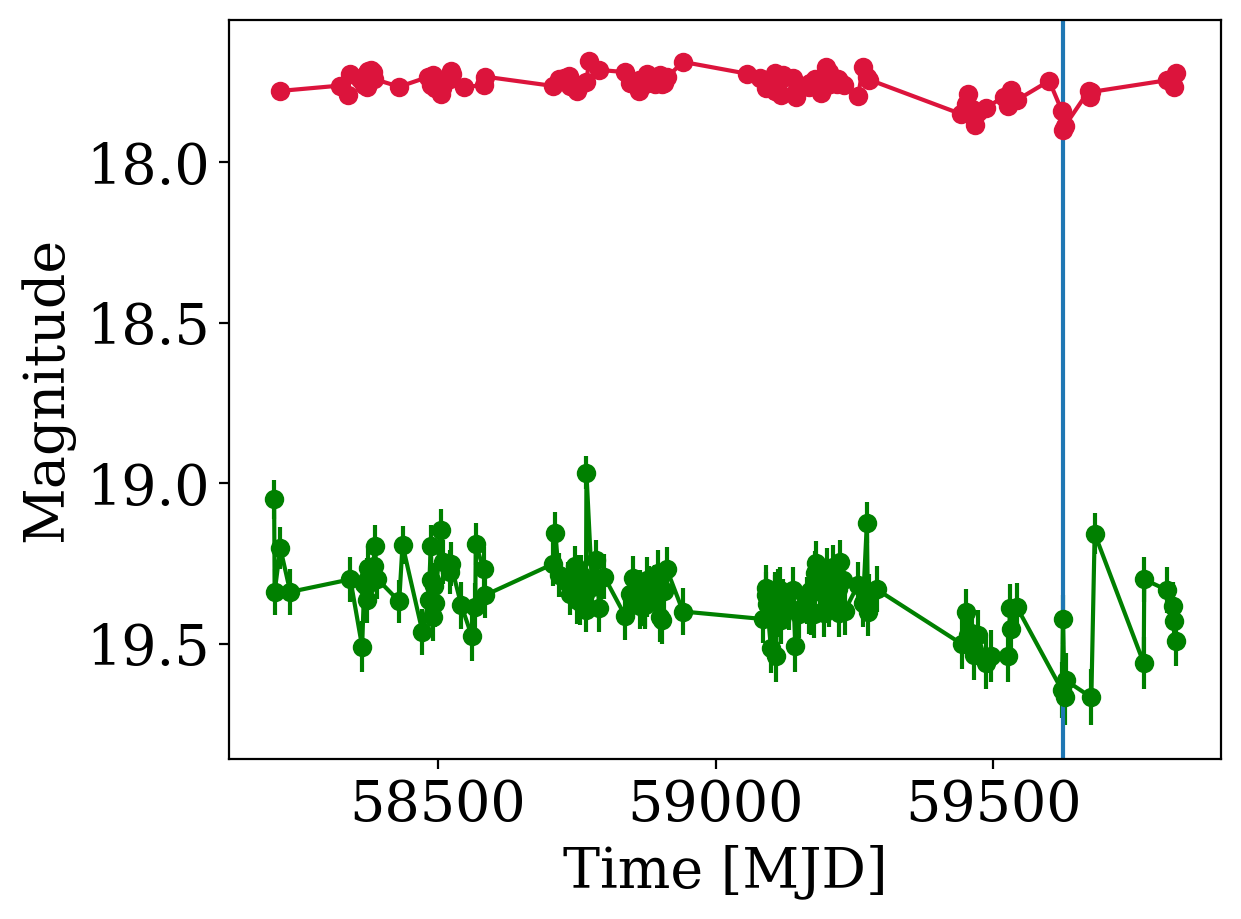

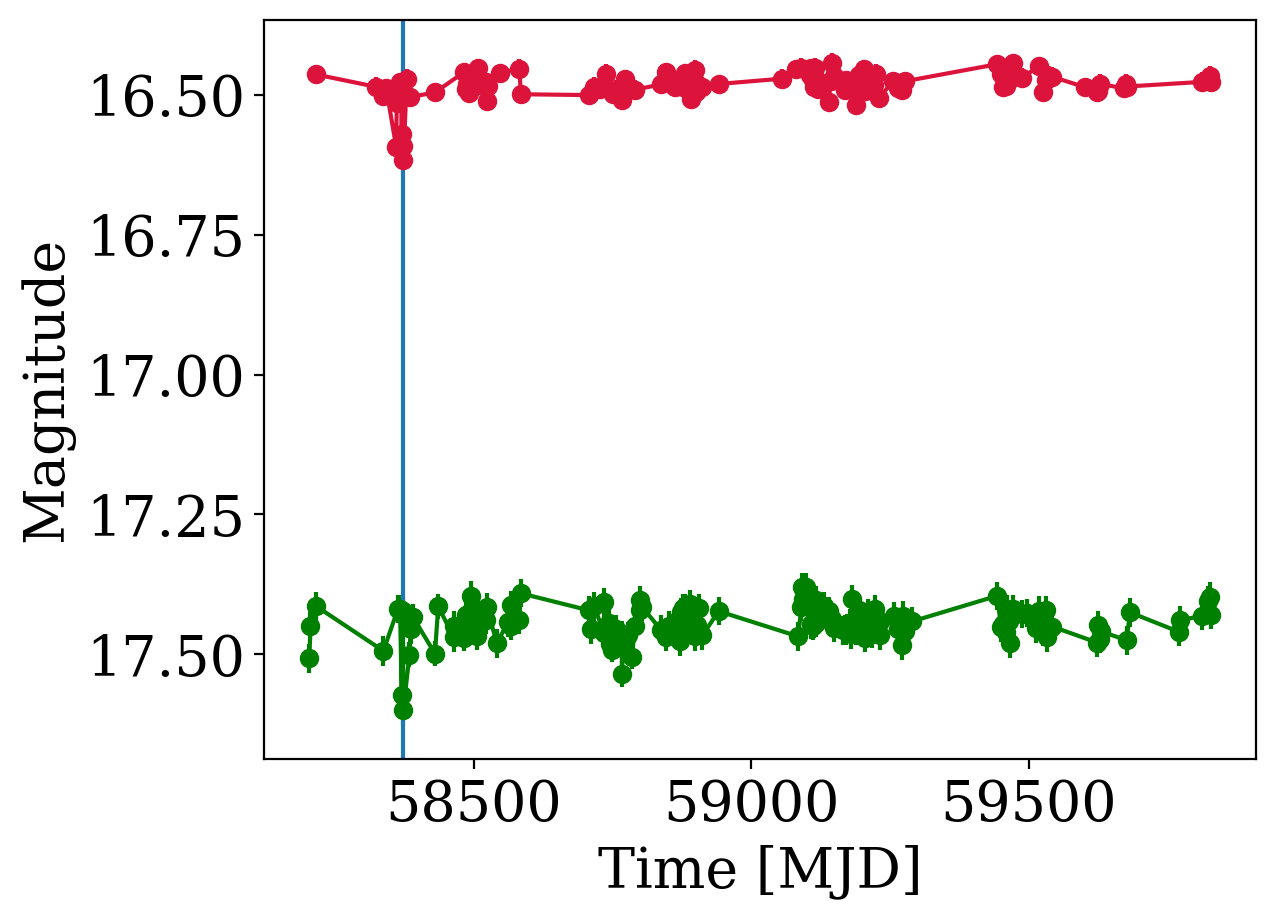

2024-02-08 17:47:36,095 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:36050'.
2024-02-08 17:47:36,099 - distributed.worker - ERROR - Scheduler was unaware of this worker 'tcp://127.0.0.1:36050'. Shutting down.


In [190]:
for i, j in tqdm(zip(demo_table[q]['best_dip_time_loc'], demo_table[q].index.values)):
    plot_lc(j, i)

In [153]:
demo_table[q].index.values

array([214833630155898880, 349501193262727168, 352191967087558656,
       366012772284104704, 375310573446889472, 377174417102340096,
       378624580723408896, 378629381460852736, 389296206100037632,
       391062914590572544, 393852297223864320, 393869823529975808,
       393891728140009472, 393999705748537344, 394003811724689408,
       394162237763223552, 394182263685775360], dtype=uint64)